# Introduction: Cloud Height Estimation Using Deep Learning

This notebook implements a sophisticated deep learning system for estimating cloud heights from aerial imagery and flight metadata. The system combines computer vision and temporal sequence analysis to predict cloud-top heights using data collected from NASA's ER-2 high-altitude aircraft.

## Core Components and Data Flow

1. Data Sources and Preprocessing
   - High-definition images from the FEGS (Fly's Eye GLM Simulator) camera system
   - Aircraft flight metadata (altitude, position, orientation, etc.)
   - Ground truth measurements from Cloud Physics LiDAR (CPL)
   - Images are preprocessed through:
     * Conversion to grayscale
     * Contrast enhancement
     * Histogram equalization
     * Optional image augmentation

2. Dataset Organization
   - Data is organized into temporal sequences where:
     * Each sequence contains 2-5 consecutive frames
     * Images are aligned with corresponding flight metadata
     * LiDAR measurements provide ground truth for training
     * Sequences are synchronized using precise timestamps
   - The dataset handles:
     * Temporal alignment of all data sources
     * Normalization of numerical values
     * Sequence padding and packing
     * Train/validation splitting

3. Model Architecture (CloudHeightEstimator)
   - Three main components working in concert:
     * CNN (ConvNext) for spatial feature extraction from images
     * Flight data processing network for metadata analysis
     * LSTM network for temporal pattern recognition
   - Additional features:
     * Attention mechanism for focusing on important time steps
     * Dropout layers for preventing overfitting
     * Huber loss for robust height prediction

4. Training Process
   - Iterative optimization using:
     * AdamW optimizer with weight decay
     * Learning rate scheduling
     * Gradient clipping
     * Batch processing of sequences
   - Validation performed using:
     * Separate validation dataset
     * Mean squared error and percentage error metrics
     * Regular model checkpointing

5. Prediction Pipeline
   - For each sequence:
     * Process multiple consecutive frames
     * Combine with flight metadata
     * Generate height prediction for the final frame
     * Compare with LiDAR ground truth
     * Denormalize predictions to real-world heights

The system aims to achieve accurate cloud height estimation while reducing dependency on expensive LiDAR equipment, potentially lowering the cost of future NASA missions while maintaining measurement accuracy.



# Google Drive setup

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install azure-storage-blob azure-identity --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 8.9 MB/s eta 0:00:00


# Imports

In [3]:
import cv2
import io
import numpy as np
import pandas as pd
import os
import random
import time
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from io import BytesIO
from PIL import Image, ImageEnhance, ImageOps
from azure.storage.blob import BlobServiceClient
from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence, pack_sequence, pad_packed_sequence, pack_padded_sequence, PackedSequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import AutoImageProcessor, ConvNextModel

# Notebook parameters

In [4]:
# If true, train model from scratch. If false, load a previously trained model
train_model = False
# If true, use a previously generated dataset from the image files. If false, regenerate it.
# Note that regenerating the dataset takes a bit of time.
cache_cloud_dataset = True

# Available flight data dates. Modify the flight_dates_to_use variable below as needed
# "20170418", "20170422", "20170508", "20170512”, "20170512"

flight_dates_to_use = ["20170418", "20170422", "20170508"]

In [5]:
# Authentication details
account_name = userdata.get('storage_account_name')
account_key = userdata.get('storage_account_key')
container_name = userdata.get('blob_container_name')

# Connection string to Azure Blob Storage
connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"

# Setup to load file from blob
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [6]:
# Parameters for parsing the NASA data
aircraft_metadata_params = [
    'DateTime_UTC', 'Lat', 'Lon', 'GPS_MSL_Alt', 'WGS_84_Alt', 'Press_Alt',
    'Grnd_Spd', 'True_Airspeed', 'Mach_Number', 'Vert_Velocity', 'True_Hdg',
    'Track', 'Drift', 'Pitch', 'Roll', 'Ambient_Temp', 'Total_Temp',
    'Static_Press', 'Dynamic_Press', 'Cabin_Pressure', 'Wind_Speed',
    'Wind_Dir', 'Solar_Zenith', 'Sun_Elev_AC', 'Sun_Az_Grd', 'Sun_Az_AC'
]

CTH_col = 'top_height'

# Aircraft Metadata
def load_metadata(blob_name):
    blob_client = container_client.get_blob_client(blob_name)
    streamdownloader = blob_client.download_blob()
    metadata_df = pd.read_csv(io.BytesIO(streamdownloader.readall()))
    return metadata_df

# LiDAR Validation Heights
def load_validation_heights(blob_name):
    blob_client = container_client.get_blob_client(blob_name)
    streamdownloader = blob_client.download_blob()
    validation_df = pd.read_csv(io.BytesIO(streamdownloader.readall()))
    return validation_df

# CloudDataset Class Explanation

## 1. Initialization and Purpose
The CloudDataset class integrates three main data sources:
- FEGS camera images (.jpg files)
- Aircraft metadata (IWG1 files)
- LiDAR validation heights (CPL files)

The class is initialized with:
- A list of date folders containing data
- Optional image transformations
- Flag to control removal of data after last valid LiDAR measurement

## 2. Data Preparation Process (_prepare_dataframe)

### a. Folder Processing
For each date folder, the system:
1. Scans for relevant files:
  - Images in folders with "_crop_corrected_aligned" suffix
  - Aircraft metadata files (IWG1)
  - LiDAR validation files (CPL)
2. Extracts timestamps from image filenames:

$$
\begin{align*}
& \textbf{Algorithm 1: Folder Processing} \\
& \textbf{Input: } \text{date_folders} \\
& \textbf{Output: } \text{processed_data} \\
& \hline \\
& \textbf{for each } \text{folder in date_folders:} \\
& \quad \text{images, timestamps, metadata, heights} \gets \emptyset \\
& \quad \textbf{for each } \text{blob in folder_contents:} \\
& \quad\quad \textbf{if } \text{blob.suffix = '.jpg' AND '_crop_corrected_aligned' in blob.name:} \\
& \quad\quad\quad \text{images.append(blob)} \\
& \quad\quad\quad \text{timestamps.append(ExtractTimestamp(blob))} \\
& \quad\quad \textbf{else if } \text{blob.startswith('IWG1'):} \\
& \quad\quad\quad \text{metadata_path} \gets \text{blob} \\
& \quad\quad \textbf{else if } \text{blob.startswith('goesrplt_CPL_layers'):} \\
& \quad\quad\quad \text{validation_path} \gets \text{blob} \\
& \quad\quad \textbf{end if} \\
& \quad \textbf{end for} \\
& \textbf{end for}
\end{align*}
$$

### b. Metadata Processing

The system processes timestamps from filenames through a standardized extraction process that:
1. Takes image filenames following the pattern "YYYYMMDD_HHMMSS_frame_n_cropped.jpg"
2. Splits the filename to extract date and time components
3. Combines and parses them into a proper datetime object

$$
\begin{align*}
& \textbf{Algorithm 2: Timestamp Extraction} \\
& \textbf{Input: } \text{filename} \\
& \textbf{Output: } \text{timestamp} \\
& \hline \\
& \textbf{Function } \text{ExtractTimestamp(filename):} \\
& \quad \text{basename} \gets \text{GetBasename(filename)} \\
& \quad \text{date_str} \gets \text{Split(basename, '')[0]} \quad \text{// YYYYMMDD} \\
& \quad \text{time_str} \gets \text{Split(basename, '')[1]} \quad \text{// HHMMSS} \\
& \quad \text{timestamp} \gets \text{ParseDateTime(date_str + time_str)} \\
& \quad \textbf{return } \text{timestamp}
\end{align*}
$$
### c. Time Feature Extraction
For temporal feature engineering, the system:
1. Processes raw datetime information from metadata
2. Converts time into fractional hours (e.g., 1:30 PM becomes 13.5)
3. Extracts day of year information for seasonal patterns
4. Adds these engineered features as new columns in the dataset

$$
\begin{align*}
& \textbf{Algorithm 3: Time Feature Extraction} \\
& \textbf{Input: } \text{metadata_df} \\
& \textbf{Output: } \text{enhanced_df} \\
& \hline \\
& \textbf{Function } \text{ExtractTimeFeatures(metadata_df):} \\
& \quad \text{hour_frac} \gets \text{Hour(df.DateTime) + Minute(df.DateTime)/60} \\
& \quad \text{day_num} \gets \text{DayOfYear(df.DateTime)} \\
& \quad \text{df['hour_of_day']} \gets \text{hour_frac} \\
& \quad \text{df['day_of_year']} \gets \text{day_num} \\
& \quad \textbf{return } \text{df}
\end{align*}
$$
### d. LiDAR Data Integration
The system aligns LiDAR measurements with image timestamps by:
1. Matching exact timestamps between images and LiDAR readings
2. Handling cases where no LiDAR data exists for a timestamp
3. Extracting cloud-top height measurements when available
4. Marking missing data appropriately with NaN values

$$
\begin{align*}
& \textbf{Algorithm 4: LiDAR Data Matching} \\
& \textbf{Input: } \text{timestamp, validation_df} \\
& \textbf{Output: } \text{height_value} \\
& \hline \\
& \textbf{Function } \text{MapTimestampToLidar(timestamp, validation_df):} \\
& \quad \text{timestamp_dt} \gets \text{ParseDateTime(timestamp)} \\
& \quad \text{matches} \gets \text{validation_df[validation_df.datetime = timestamp_dt]} \\
& \quad \textbf{if } \text{matches.empty:} \\
& \quad\quad \textbf{return } \text{NaN} \\
& \quad \textbf{else:} \\
& \quad\quad \textbf{return } \text{matches.top_height[0]}
\end{align*}
$$
### e. Sequence Management
To prepare data for the RNN model, the system:
1. Identifies sequences of consecutive frames
2. Calculates sequence lengths based on valid LiDAR measurements
3. Marks the start and end of each sequence
4. Ensures proper sequence alignment for training

$$
\begin{align*}
& \textbf{Algorithm 5: Sequence Length Calculation} \\
& \textbf{Input: } \text{dataframe} \\
& \textbf{Output: } \text{dataframe with sequence lengths} \\
& \hline \\
& \textbf{Function } \text{AddSequenceLengths(dataframe):} \\
& \quad \text{seq_start} \gets \text{0} \\
& \quad \textbf{for } \text{i in range(len(dataframe)):} \\
& \quad\quad \textbf{if } \text{not IsNaN(dataframe[i].validation_height):} \\
& \quad\quad\quad \text{length} \gets \text{i - seq_start + 1} \\
& \quad\quad\quad \text{dataframe[seq_start:i].sequence_length} \gets \text{length} \\
& \quad\quad\quad \text{seq_start} \gets \text{i + 1} \\
& \quad \textbf{return } \text{dataframe}
\end{align*}
$$
### f. Data Normalization
The normalization process handles different types of data:
1. Scales numerical values to a standardized range (0-1)
2. Applies special handling for validation heights:
   - Only normalizes non-NaN values
   - Preserves NaN markers for missing data
3. Maintains normalization parameters for later denormalization
4. Handles all flight metadata consistently

$$
\begin{align*}
& \textbf{Algorithm 6: Value Normalization} \\
& \textbf{Input: } \text{dataframe, columns} \\
& \textbf{Output: } \text{normalized dataframe} \\
& \hline \\
& \textbf{Function } \text{NormalizeValues(dataframe, columns):} \\
& \quad \textbf{for } \text{col in columns:} \\
& \quad\quad \text{min_val} \gets \text{Min(dataframe[col])} \\
& \quad\quad \text{max_val} \gets \text{Max(dataframe[col])} \\
& \quad\quad \textbf{if } \text{col = 'validation_height':} \\
& \quad\quad\quad \text{mask} \gets \text{not IsNaN(dataframe[col])} \\
& \quad\quad\quad \text{dataframe[col][mask]} \gets \text{(dataframe[col][mask] - min_val)/(max_val - min_val)} \\
& \quad\quad \textbf{else:} \\
& \quad\quad\quad \text{dataframe[col]} \gets \text{(dataframe[col] - min_val)/(max_val - min_val)} \\
& \quad \textbf{return } \text{dataframe}
\end{align*}
$$

## Key Features
The resulting dataset provides:
1. Temporally aligned sequences of:
   - Normalized image data
   - Processed flight metadata
   - LiDAR ground truth measurements
2. Sequence length information for RNN processing
3. Interpolated missing values where appropriate
4. Normalized numerical values
5. Efficient data access methods

The algorithmic structure ensures:
- Consistent temporal alignment
- Proper handling of missing data
- Efficient memory usage
- Robust error checking
- Flexible data transformation

# CloudDataset Class

In [7]:
# CloudDataset classes integrating all 3 data sources: FEGS Images, Aircraft Metadata and LiDAR Validation Heights with temporal alignment
class CloudDataset(Dataset):
    def __init__(self, date_folders, transform=None, drop_after_last_validation=True):
        self.date_folders = date_folders
        self.transform = transform
        self.drop_after_last_validation = drop_after_last_validation
        self.data_df = self._prepare_dataframe()

    def _prepare_dataframe(self):
        """
        Iterates over the date folders in azure blob storage and loads:
          1. .jpg Images from each sub-directory in the folder with '_crop_corrected_aligned' in the name.
          2. Aircraft Metadata with 1-1 time alignment with the images.
          3. LiDAR Validation Heights, mapped using timestamp, if not available filled with NaN.
        Creates a df with following columns:
            timestamp, image_path, [...aircraft_metadata_params...], validation_height
        """
        image_paths, timestamps, metadata_rows, validation_heights = [], [], [], []

        for folder in self.date_folders:
            print(f"Processing folder: {folder}")
            folder_image_paths, folder_timestamps, folder_metadata_rows, folder_validation_heights = [], [], [], []

            blob_list = container_client.list_blobs(name_starts_with=folder)
            metadata_path, validation_path = None, None
            for blob in blob_list:
                # extract image paths of all .jpg images in cropped folders
                if blob.name.endswith(".jpg") and "_crop_corrected_aligned" in blob.name:
                    folder_image_paths.append(blob.name)
                    folder_timestamps.append(self._extract_timestamp_from_filename(blob.name))
                # extract the aircraft metadata file path
                if blob.name.startswith(f"{folder}/IWG1.") and "processed" in blob.name:
                    metadata_path = blob.name
                # extract the LiDAR validation file path
                if blob.name.startswith(f"{folder}/goesrplt_CPL_layers_") and blob.name.endswith("_processed.txt"):
                    validation_path = blob.name

            # load aircraft metadata and LiDAR validation data
            if metadata_path:
                metadata_df = load_metadata(metadata_path)
            if validation_path:
                validation_df = load_validation_heights(validation_path)

            # prepare LiDAR validation data
            validation_df['datetime_combined'] = validation_df['date'] + ' ' + validation_df['timestamp']
            validation_df['datetime_combined'] = validation_df['datetime_combined'].str.split('.').str[0]
            validation_df['datetime_combined'] = pd.to_datetime(validation_df['datetime_combined'], format="%Y-%m-%d %H:%M:%S")

            # prepare aircraft metadata
            metadata_df = metadata_df[aircraft_metadata_params]
            metadata_df['DateTime_UTC'] = metadata_df['DateTime_UTC'].str.split('.').str[0]
            metadata_df = self._extract_time_features(metadata_df)  # Add hour_of_day and day_of_year

            metadata_timestamps = pd.to_datetime(metadata_df['DateTime_UTC'], format="%Y-%m-%d %H:%M:%S")
            metadata_df = metadata_df.set_index(metadata_timestamps)
            aligned_metadata = pd.DataFrame(index=pd.to_datetime(folder_timestamps, format="%H:%M:%S"))
            aligned_metadata = aligned_metadata.join(metadata_df, how='left')
            aligned_metadata = aligned_metadata[aircraft_metadata_params + ['hour_of_day', 'day_of_year']]

            folder_metadata_rows.extend(aligned_metadata.values.tolist())

            # extract LiDAR validation height exactly matching the timestamp where available, else NaN
            for ts in folder_timestamps:
                cth = self._map_timestamp_to_lidar(ts, validation_df)
                folder_validation_heights.append(cth)

            # Create a folder-level DataFrame
            folder_data = {
                'timestamp': folder_timestamps,
                'image_path': folder_image_paths,
                **{param: [row[i] for row in folder_metadata_rows] for i, param in enumerate(aircraft_metadata_params + ['hour_of_day', 'day_of_year'])},
                'validation_height': folder_validation_heights
            }
            folder_df = pd.DataFrame(folder_data)

            # Conditionally remove rows after the last valid validation_height in this folder
            if self.drop_after_last_validation:
                last_valid_index = folder_df['validation_height'].last_valid_index()
                if last_valid_index is not None:
                    folder_df_cleaned = folder_df.loc[:last_valid_index].copy()  # Use .copy() to ensure independence
                else:
                    folder_df_cleaned = folder_df.copy()  # In case there are no valid entries
            else:
                folder_df_cleaned = folder_df  # Keep all rows if dropping is disabled

            # Extend to the global lists
            image_paths.extend(folder_df_cleaned['image_path'].tolist())
            timestamps.extend(folder_df_cleaned['timestamp'].tolist())
            metadata_rows.extend(folder_df_cleaned[aircraft_metadata_params + ['hour_of_day', 'day_of_year']].values.tolist())
            validation_heights.extend(folder_df_cleaned['validation_height'].tolist())

            # Print the lengths for the current folder
            print(f"Folder {folder}:")
            print(f"  Number of images: {len(folder_df_cleaned['image_path'])}")
            print(f"  Number of timestamps: {len(folder_df_cleaned['timestamp'])}")
            print(f"  Number of metadata rows: {len(folder_df_cleaned)}")
            print(f"  Number of validation heights: {len(folder_df_cleaned['validation_height'])}")

        # Print the final lengths after processing all folders
        print("After processing all folders combined:")
        print(f"  Total number of images: {len(image_paths)}")
        print(f"  Total number of timestamps: {len(timestamps)}")
        print(f"  Total number of metadata rows: {len(metadata_rows)}")
        print(f"  Total number of validation heights: {len(validation_heights)}")

        # Check for any mismatches
        if not (len(image_paths) == len(timestamps) == len(metadata_rows) == len(validation_heights)):
            print("Error: Length mismatch detected!")
            print(f"  Images: {len(image_paths)}")
            print(f"  Timestamps: {len(timestamps)}")
            print(f"  Metadata rows: {len(metadata_rows)}")
            print(f"  Validation heights: {len(validation_heights)}")
            return None

        # combine all aligned data in a df
        data = {
            'timestamp': timestamps,
            'image_path': image_paths,
            **{param: [row[i] for row in metadata_rows] for i, param in enumerate(aircraft_metadata_params + ['hour_of_day', 'day_of_year'])},
            'validation_height': validation_heights
        }
        df = pd.DataFrame(data)
        df = df.drop(columns=['DateTime_UTC'])

        # Print columns with NaN values before interpolation
        self._print_columns_with_nan(df)

        # Interpolate missing values, excluding 'validation_height'
        df = self._interpolate_missing_values(df)

        # Add sequence length information for RNN
        self._add_sequence_length_column(df)
        return df

    def _extract_time_features(self, df):
        """
        Extracts hour of day and day of year from the DateTime_UTC column.
        Adds 'hour_of_day' (with fractional hour) and 'day_of_year' as new columns in the DataFrame.
        """
        df['DateTime_UTC'] = pd.to_datetime(df['DateTime_UTC'], format="%Y-%m-%d %H:%M:%S")
        df['hour_of_day'] = df['DateTime_UTC'].dt.hour + df['DateTime_UTC'].dt.minute / 60
        df['day_of_year'] = df['DateTime_UTC'].dt.dayofyear
        return df

    def _extract_timestamp_from_filename(self, filename):
        """
        Extracts the timestamp from the image filename on the blob.
        path/to/blob/YYYYMMDD_HHMMSS_frame_n_cropped.jpg -> %Y%m%d%H%M%S
        """
        filename = os.path.basename(filename)
        date_str = filename.split("_")[0]
        time_str = filename.split("_")[1]
        timestamp = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S")
        return timestamp


    def _map_timestamp_to_lidar(self, timestamp, validation_df):
        """
        extract LiDAR validation height exactly matching the timestamp where available, else NaN
        """
        validation_df['datetime_combined'] = pd.to_datetime(validation_df['datetime_combined'], format="%Y-%m-%d %H:%M:%S")
        timestamp_dt = pd.to_datetime(timestamp, format="%Y-%m-%d %H:%M:%S")
        exact_match = validation_df[validation_df['datetime_combined'] == timestamp_dt]
        return exact_match[CTH_col].values[0] if not exact_match.empty else np.nan


    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        """
        Retrieve a data record from the dataset for a given index.
        Returns loaded and transformed image, metadata and validation height associated with that image if available.
        """
        row = self.data_df.iloc[idx]

        image_path = row['image_path']
        blob_client = container_client.get_blob_client(image_path)
        streamdownloader = blob_client.download_blob()
        img_data = streamdownloader.readall()
        img = Image.open(io.BytesIO(img_data)).convert("RGB")
        if self.transform:
            img = self.transform(img)

        metadata = torch.tensor([row[param] for param in aircraft_metadata_params], dtype=torch.float32)
        validation_height = torch.tensor([row['validation_height']], dtype=torch.float32)

        return img, metadata, validation_height

    def _add_sequence_length_column(self, df):
        # Initialize a new column to NaN
        df['sequence_length'] = np.nan

        # Track the start of each sequence
        sequence_start = 0

        # Iterate through the dataframe to detect when a validation_height exists
        for i in range(len(df)):
            if not pd.isna(df.loc[i, 'validation_height']):
                # We found the end of a sequence, so mark the previous sequence images
                sequence_length = i - sequence_start
                df.loc[sequence_start:i, 'sequence_length'] = sequence_length + 1  # Using count (1-based index)
                sequence_start = i + 1  # Move the start to the next sequence

        # Ensure all sequence_length values are integers (if any were missed)
        df['sequence_length'] = df['sequence_length'].astype(int)

        return df

    def _print_columns_with_nan(self, df):
        """
        Prints the names of columns in the DataFrame that contain NaN values.
        """
        columns_with_nan = df.columns[df.isna().any()].tolist()
        if columns_with_nan:
            print("Columns with NaN values:")
            for col in columns_with_nan:
                print(col)
        else:
            print("No columns with NaN values.")

    def _interpolate_missing_values(self, df, exclude_columns=['validation_height', 'timestamp', 'image_path']):
        """
        Interpolates missing values in the DataFrame for all columns except specified ones.
        """
        # Create a copy to avoid modifying the original DataFrame
        df = df.copy()

        # Store excluded columns
        excluded_data = {col: df[col].copy() for col in exclude_columns if col in df.columns}

        # Convert all object-type columns in df to numeric where possible
        df = df.infer_objects()

        # Get columns for interpolation (excluding specified columns)
        columns_to_interpolate = [col for col in df.columns if col not in exclude_columns]

        # Convert columns to numeric where possible
        for col in columns_to_interpolate:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except (ValueError, TypeError):
                continue

        # Perform interpolation only on numeric columns
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        if not numeric_columns.empty:
            df[numeric_columns] = df[numeric_columns].interpolate(
                method='linear',
                axis=0,
                limit_direction='both'
            )

        # Restore excluded columns
        for col, data in excluded_data.items():
            df[col] = data

        return df

# Create the CloudDataset or retrieve it from cache

In [8]:
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])

augmentations = transforms.Compose([
])

# Change the cache_cloud_dataset variable at the start to make this either
# generate the CloudDataset (takes some time) or use a cached version on Google Drive
if cache_cloud_dataset:
    full_dataframe = pd.read_csv('/content/drive/My Drive/datasets/train_dataset.csv')
else:
    # Gather Data Dynamically from Azure
    # Create the full CloudDataset without splitting initially
    full_dataset = CloudDataset(flight_dates_to_use, transform=None)
    # Extract the full dataframe from CloudDataset
    full_dataframe = full_dataset.data_df
    # Ensure folder exists
    os.makedirs('/content/drive/My Drive/datasets', exist_ok=True)
    # Save the dataframe directly to Google Drive
    full_dataframe.to_csv('/content/drive/My Drive/datasets/train_dataset.csv', index=False, header=True)

In [9]:
full_dataframe.to_csv('train_dataset.csv', index=False, header=True)

In [10]:
full_dataframe.head(20)

,timestamp,image_path,Lat,Lon,GPS_MSL_Alt,WGS_84_Alt,Press_Alt,Grnd_Spd,True_Airspeed,Mach_Number,...,Wind_Speed,Wind_Dir,Solar_Zenith,Sun_Elev_AC,Sun_Az_Grd,Sun_Az_AC,hour_of_day,day_of_year,validation_height,sequence_length
0,2017-04-18 17:57:06,20170418/170418_175706_183328_frames_crop_corr...,34.605530,-86.583990,19970.3,19970.4,65040.0,202.7,200.4,0.690,...,3.9,232.8,23.7,67.4,-173.6,-172.6,17.95,108.0,NaN,4
1,2017-04-18 17:57:07,20170418/170418_175706_183328_frames_crop_corr...,34.607351,-86.583990,19970.1,19970.3,65042.5,202.7,200.6,0.691,...,3.9,232.7,23.7,67.4,-173.6,-172.7,17.95,108.0,NaN,4
2,2017-04-18 17:57:08,20170418/170418_175706_183328_frames_crop_corr...,34.609173,-86.583989,19969.8,19970.1,65045.0,202.8,200.9,0.692,...,3.7,235.9,23.7,67.3,-173.6,-172.6,17.95,108.0,NaN,4
3,2017-04-18 17:57:09,20170418/170418_175706_183328_frames_crop_corr...,34.610995,-86.583988,19969.6,19969.8,65045.0,202.8,201.0,0.692,...,3.7,236.4,23.7,67.3,-173.6,-172.5,17.95,108.0,13161.0,4
4,2017-04-18 17:57:10,20170418/170418_175706_183328_frames_crop_corr...,34.612817,-86.583987,19969.4,19969.6,65037.5,202.8,200.7,0.691,...,3.7,236.4,23.7,67.4,-173.6,-172.5,17.95,108.0,NaN,5
5,2017-04-18 17:57:11,20170418/170418_175706_183328_frames_crop_corr...,34.614639,-86.583986,19969.0,19969.4,65037.5,202.8,200.8,0.692,...,3.6,236.9,23.7,67.4,-173.6,-172.7,17.95,108.0,NaN,5
6,2017-04-18 17:57:12,20170418/170418_175706_183328_frames_crop_corr...,34.616455,-86.583987,19968.6,19969.0,65032.5,202.8,201.0,0.692,...,3.6,236.3,23.7,67.4,-173.6,-172.8,17.95,108.0,NaN,5
7,2017-04-18 17:57:13,20170418/170418_175706_183328_frames_crop_corr...,34.618278,-86.583986,19968.3,19968.6,65032.5,202.8,201.1,0.692,...,3.5,236.4,23.7,67.4,-173.6,-172.7,17.95,108.0,NaN,5
8,2017-04-18 17:57:14,20170418/170418_175706_183328_frames_crop_corr...,34.620100,-86.583985,19968.1,19968.3,65032.5,202.8,201.0,0.692,...,3.5,236.3,23.7,67.4,-173.6,-172.4,17.95,108.0,13131.0,5
9,2017-04-18 17:57:15,20170418/170418_175706_183328_frames_crop_corr...,34.621922,-86.583984,19967.9,19968.1,65032.5,202.8,201.0,0.692,...,3.5,236.4,23.7,67.4,-173.5,-172.3,17.95,108.0,NaN,5


In [11]:
full_dataframe.tail(20)

,timestamp,image_path,Lat,Lon,GPS_MSL_Alt,WGS_84_Alt,Press_Alt,Grnd_Spd,True_Airspeed,Mach_Number,...,Wind_Speed,Wind_Dir,Solar_Zenith,Sun_Elev_AC,Sun_Az_Grd,Sun_Az_AC,hour_of_day,day_of_year,validation_height,sequence_length
37584,2017-05-08 23:59:39,20170508/170508_235024_002714_frames_crop_corr...,40.767930,-104.304358,19714.1,19713.4,63887.5,206.8,204.6,0.7010,...,2.4,110.8,68.5,20.7,-85.2,-31.7,23.983333,128.0,NaN,5
37585,2017-05-08 23:59:40,20170508/170508_235024_002714_frames_crop_corr...,40.769039,-104.306177,19714.8,19714.1,63890.0,206.8,204.6,0.7020,...,2.4,110.6,68.5,20.8,-85.2,-31.7,23.983333,128.0,NaN,5
37586,2017-05-08 23:59:41,20170508/170508_235024_002714_frames_crop_corr...,40.770145,-104.308003,19715.2,19714.8,63892.5,206.7,204.6,0.7020,...,2.2,108.7,68.5,20.9,-85.2,-31.7,23.983333,128.0,NaN,5
37587,2017-05-08 23:59:42,20170508/170508_235024_002714_frames_crop_corr...,40.771254,-104.310166,19715.5,19715.2,63890.0,206.7,204.6,0.7020,...,2.1,108.4,68.5,20.9,-85.2,-31.7,23.983333,128.0,NaN,5
37588,2017-05-08 23:59:43,20170508/170508_235024_002714_frames_crop_corr...,40.772363,-104.311985,19715.4,19715.5,63887.5,206.7,204.6,0.7010,...,2.3,110.1,68.5,20.9,-85.2,-31.7,23.983333,128.0,13011.0,5
37589,2017-05-08 23:59:44,20170508/170508_235024_002714_frames_crop_corr...,40.773472,-104.314147,19715.2,19715.4,63887.5,206.7,204.5,0.7010,...,2.4,110.9,68.5,20.9,-85.2,-31.7,23.983333,128.0,NaN,5
37590,2017-05-08 23:59:45,20170508/170508_235024_002714_frames_crop_corr...,40.774581,-104.315967,19714.9,19715.2,63885.0,206.7,204.6,0.7010,...,2.4,111.1,68.5,20.9,-85.2,-31.8,23.983333,128.0,NaN,5
37591,2017-05-08 23:59:46,20170508/170508_235024_002714_frames_crop_corr...,40.775689,-104.317786,19714.5,19714.9,63885.0,206.7,204.5,0.7010,...,2.4,111.0,68.5,20.9,-85.2,-31.8,23.983333,128.0,NaN,5
37592,2017-05-08 23:59:47,20170508/170508_235024_002714_frames_crop_corr...,40.776798,-104.319948,19714.0,19714.5,63882.5,206.7,204.5,0.7010,...,2.4,111.1,68.5,20.9,-85.2,-31.8,23.983333,128.0,NaN,5
37593,2017-05-08 23:59:48,20170508/170508_235024_002714_frames_crop_corr...,40.777907,-104.321767,19713.4,19714.0,63880.0,206.7,204.4,0.7010,...,2.4,111.1,68.5,20.9,-85.2,-31.8,23.983333,128.0,12951.0,5


# Random Scaling and Cropping Strategy

## Motivation
The goal behind this data augmentation strategy is to help the model become more robust at estimating cloud heights when the LiDAR measurement point isn't always in the center of the image. This is important because:

1. **Original Data Limitation**
   - LiDAR measurements are always taken at the exact center of each image
   - This could cause the model to overfit to center-focused features
   - Real-world applications may need height estimates from different parts of the image

2. **Spatial Understanding**
   - Want the model to understand cloud height features regardless of their position
   - Need to learn relationships between cloud features across the entire image
   - Important for generalizing to different viewing angles and positions

## Implementation Strategy

### 1. Random Cropping (random_crop_sequence)
$$
\begin{align*}
& \textbf{Algorithm: Random Crop Sequence} \\
& \textbf{Input: } \text{image_sequence, min_crop_size = 384} \\
& \textbf{Output: } \text{cropped_sequence, new_center_coords} \\
& \hline \\
& \text{orig_height, orig_width} \gets \text{image_size} \\
& \text{crop_size} \gets \text{random_int(min_crop_size, min(orig_height, orig_width))} \\
& \text{top} \gets \text{random_int(0, orig_height - crop_size)} \\
& \text{left} \gets \text{random_int(0, orig_width - crop_size)} \\
& \text{orig_center} \gets \text{(orig_width}/2\text{, orig_height}/2\text{)} \\
& \text{new_center} \gets \text{(orig_center.x - left, orig_center.y - top)} \\
& \text{cropped_sequence} \gets \text{crop_images(sequence, top, left, crop_size)}
\end{align*}
$$

Key Features:
- Random crop size between minimum (384) and image dimension
- Random position for the crop window
- Maintains aspect ratio (square crop)
- Original center point is transformed to new coordinates

### 2. Resizing (resize_sequence_and_adjust_center)
$$
\begin{align*}
& \textbf{Algorithm: Resize and Adjust Center} \\
& \textbf{Input: } \text{cropped_sequence, center_coords, target_size = 384} \\
& \textbf{Output: } \text{resized_sequence, adjusted_center_coords} \\
& \hline \\
& \text{scale_factor} \gets \text{target_size}/\text{crop_size} \\
& \text{new_center.x} \gets \text{center_coords.x} \times \text{scale_factor} \\
& \text{new_center.y} \gets \text{center_coords.y} \times \text{scale_factor} \\
& \text{resized_sequence} \gets \text{resize_images(cropped_sequence, target_size)}
\end{align*}
$$

## Benefits of This Approach

1. **Data Augmentation**
   - Effectively multiplies training data
   - Creates variations in LiDAR measurement position
   - Introduces scale variation while preserving aspect ratios

2. **Model Robustness**
   - Forces model to look at cloud features everywhere in image
   - Prevents overfitting to center-specific patterns
   - Better generalization to different viewing conditions

3. **Training Stability**
   - Consistent final image size (384x384)
   - Maintains original aspect ratios
   - Preserves relative spatial relationships

4. **Validation Strategy**
   - During validation, no random cropping is applied
   - Center point remains fixed for validation
   - Allows fair comparison with ground truth

# Random Scaling and Cropping Example

Original Image:
- Size: 800 x 800
- LiDAR measurement point: (400, 400) [exact center]

Let's say our random crop generates:
- Crop size: 500 x 500 (randomly chosen between 384 and 800)
- Top-left position: (220, 150) [randomly chosen to fit the 500x500 crop]

Step 1: Crop Transformation
```
Original center: (400, 400)
Crop offset: (220, 150)
New center = Original center - Crop offset
New center = (400-220, 400-150) = (180, 250)
```
So in our 500x500 cropped image, the LiDAR point is now at (180, 250) - notably off-center

Step 2: Resize to 384x384
```
Scale factor = 384/500 = 0.768
Final center = (180 * 0.768, 250 * 0.768) = (138, 192)
```

Final Result:
- Image size: 384 x 384
- LiDAR point: (138, 192)
- Original center point has moved significantly off-center
  - Horizontally: shifted from center by 54 pixels (384/2 - 138 = 54)
  - Vertically: shifted from center by 0 pixels (384/2 - 192 = 0)

This asymmetric transformation better illustrates how the cropping strategy creates variations in the LiDAR measurement position, forcing the model to learn to estimate cloud heights from features across the entire image rather than just the center region.

Here's a visual example of the process:

In [12]:
%%html
<svg width="1000" height="400" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 1000 400">
    <!-- Original 800x800 Image -->
    <rect x="20" y="20" width="320" height="320" fill="none" stroke="#666666" stroke-width="2"/>
    <text x="20" y="15" font-family="Arial" font-size="14">Original Image (800 x 800)</text>
    <circle cx="180" cy="180" r="4" fill="red"/>
    <text x="140" y="150" font-family="Arial" font-size="12" fill="red">LiDAR Point (400, 400)</text>

    <!-- Crop Box -->
    <rect x="108" y="80" width="200" height="200" fill="rgba(0, 102, 204, 0.1)" stroke="#0066cc" stroke-width="2"/>
    <text x="108" y="75" font-family="Arial" font-size="14" fill="#0066cc">Crop Region (500 x 500)</text>
    <text x="108" y="300" font-family="Arial" font-size="12" fill="#0066cc">Starting at (220, 150)</text>

    <!-- Arrow -->
    <path d="M 370 180 L 430 180" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>

    <!-- Cropped Image -->
    <rect x="460" y="20" width="200" height="200" fill="none" stroke="#0066cc" stroke-width="2"/>
    <text x="460" y="15" font-family="Arial" font-size="14">Cropped Image (500 x 500)</text>
    <circle cx="532" cy="130" r="4" fill="red"/>
    <text x="492" y="100" font-family="Arial" font-size="12" fill="red">LiDAR Point (180, 250)</text>

    <!-- Arrow -->
    <path d="M 690 180 L 750 180" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>

    <!-- Final Resized Image -->
    <rect x="780" y="58" width="154" height="154" fill="none" stroke="#009933" stroke-width="2"/>
    <text x="780" y="53" font-family="Arial" font-size="14">Resized (384 x 384)</text>
    <circle cx="836" cy="147" r="4" fill="red"/>
    <text x="796" y="117" font-family="Arial" font-size="12" fill="red">LiDAR Point (138, 192)</text>

    <!-- Arrowhead definition -->
    <defs>
        <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
            <polygon points="0 0, 10 3.5, 0 7" fill="black"/>
        </marker>
    </defs>

    <!-- Grid overlay on middle image to show scale -->
    <g stroke="rgba(128,128,128,0.2)">
        <line x1="460" y1="70" x2="660" y2="70"/>
        <line x1="460" y1="120" x2="660" y2="120"/>
        <line x1="460" y1="170" x2="660" y2="170"/>

        <line x1="510" y1="20" x2="510" y2="220"/>
        <line x1="560" y1="20" x2="560" y2="220"/>
        <line x1="610" y1="20" x2="610" y2="220"/>
    </g>
</svg>

# Image loading and augmentation

In [13]:
def load_image_from_blob_cv(blob_img):
    """
    Loads the image from the Azure Blob Storage using OpenCV and returns it as a numpy array.
    Args:
        blob_img (str): name of the blob image in the container
    Returns:
        (numpy.ndarray): loaded image in greyscale
    """
    blob_client = container_client.get_blob_client(blob_img)
    streamdownloader = blob_client.download_blob()
    blob_data = streamdownloader.readall()
    image_array = np.asarray(bytearray(blob_data), dtype=np.uint8)
    img_bgr = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

def augment_greyscale_image(img, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5), blur=True):
    """
    Augments the Greyscale image to enhance the feature of the cloud. Includes:
      1. Contrast and Brightness
      2. Gaussian Blur
      3. Histogram Equalization
      4. Sharpening
    Args:
        img (numpy.ndarray): greyscale image
        contrast_factor (float): contrast factor
        brightness_beta (int): brightness factor
        kernel_size (tuple): kernel size for Gaussian Blur
        blur (bool): whether to apply Gaussian Blur
    Returns:
        (numpy.ndarray): augmented image
    """
    img_enhanced = cv2.convertScaleAbs(img, alpha=contrast_factor, beta=brightness_beta)
    if blur:
        img_enhanced = cv2.GaussianBlur(img_enhanced, kernel_size, 0)
    img_enhanced = cv2.equalizeHist(img_enhanced)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img_enhanced)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(img_enhanced, -1, kernel)

def undistort_fisheye_image(img, K, D, balance=0.5):
    """
    Undistorts a fisheye image using the intrinsic camera matrix and distortion coefficients.

    Args:
        img (numpy.ndarray): The distorted fisheye image.
        K (numpy.ndarray): The camera matrix.
        D (numpy.ndarray): The distortion coefficients.
        balance (float): Balance between the undistorted and distorted image. 0.0 means fully zoomed in,
                         1.0 means fully zoomed out.

    Returns:
        undistorted_img (numpy.ndarray): The undistorted image.
    """
    h, w = img.shape[:2]

    # Generate new camera matrix based on free scaling parameter (alpha=1 keeps all the image)
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), np.eye(3), balance=balance)

    # Undistort the image
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, (w, h), cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    return undistorted_img

def visualize_augmentations_cv(image_list, enhance=True):
    """
    Visualizes original and augmented greyscale images using OpenCV.
    Args:
        image_list (list): List of image paths in Azure Blob Storage
        enhance (bool): Whether to apply image augmentation
    Returns:
        None
    """
    fig, axes = plt.subplots(len(image_list), 3, figsize=(15, 5 * len(image_list)))

    for idx, blob_img in enumerate(image_list):
        original_image = load_image_from_blob_cv(blob_img)
        greyscale_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
        augmented_image = greyscale_image.copy()

        if enhance:
            augmented_image = augment_greyscale_image(augmented_image, contrast_factor=1.5, brightness_beta=30, kernel_size=(5, 5))

        axes[idx, 0].imshow(original_image)
        axes[idx, 0].set_title("Original Image (RGB)")
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(greyscale_image, cmap='gray')
        axes[idx, 1].set_title("Greyscale Image")
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(augmented_image, cmap='gray')
        axes[idx, 2].set_title("Augmented Image")
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

def random_crop_sequence(image_sequence, crop_size_minimum=384):
    """
    Apply identical random crop to a sequence of images and ensure randomness in cropping location.
    The crop size is randomly selected between the minimum size (crop_size_minimum) and the full image size.

    Args:
        image_sequence: A list or tensor of images in the sequence (each image should be the same size).
        crop_size_minimum: The minimum crop size (default is 384).

    Returns:
        cropped_sequence: The cropped sequence of images.
        new_center_coords: The new coordinates of the center pixel after cropping.
    """
    # Get the height and width of the original images
    orig_height, orig_width = image_sequence[0].shape[-2:]

    # Randomly select the crop size between the minimum and full image size
    max_crop_size = min(orig_height, orig_width)
    crop_h = random.randint(crop_size_minimum, max_crop_size)
    crop_w = crop_h  # Keeping the crop square for simplicity

    # Ensure that the crop size is smaller than the original image
    assert crop_h <= orig_height and crop_w <= orig_width, "Crop size must be smaller than the original image size."

    # Original center coordinates of the image
    orig_center_x = orig_width // 2
    orig_center_y = orig_height // 2

    # Randomly select the top-left corner for the crop
    top = random.randint(0, orig_height - crop_h)
    left = random.randint(0, orig_width - crop_w)

    # Apply the same crop to each image in the sequence
    cropped_sequence = [TF.crop(img, top, left, crop_h, crop_w) for img in image_sequence]

    # Calculate the new center coordinates based on the original center relative to the cropped region
    new_center_x = orig_center_x - left  # Adjust the original center x based on the crop left offset
    new_center_y = orig_center_y - top   # Adjust the original center y based on the crop top offset

    # Ensure the new center coordinates are still within the cropped image bounds
    new_center_x = max(0, min(new_center_x, crop_w - 1))
    new_center_y = max(0, min(new_center_y, crop_h - 1))

    return cropped_sequence, (new_center_x, new_center_y)

def resize_sequence_and_adjust_center(cropped_sequence, new_center_coords, target_size=(384, 384)):
    """
    Resize the cropped sequence to a target size and adjust the center coordinates accordingly.

    Args:
        cropped_sequence: The list of cropped images.
        new_center_coords: The (x, y) coordinates of the center in the cropped image.
        target_size: The desired output size (height, width), default is (384, 384).

    Returns:
        resized_sequence: The resized sequence of images.
        resized_center_coords: The adjusted (x, y) coordinates of the center in the resized images.
    """
    crop_h, crop_w = cropped_sequence[0].shape[-2:]  # Get height and width of the cropped image
    target_h, target_w = target_size  # Desired target size (e.g., 384x384)

    # Calculate the scaling factors for height and width
    scale_x = target_w / crop_w
    scale_y = target_h / crop_h

    # Resize each image in the sequence to the target size
    resized_sequence = [TF.resize(img, size=target_size) for img in cropped_sequence]

    # Adjust the center coordinates according to the scaling factor
    new_center_x, new_center_y = new_center_coords
    resized_center_x = int(new_center_x * scale_x)
    resized_center_y = int(new_center_y * scale_y)

    return resized_sequence, (resized_center_x, resized_center_y)

In [14]:
images = [
    "20170418/170418_175706_183328_frames/20170418_175706_frame_0.jpg",
    "20170418/170418_175706_183328_frames/20170418_175707_frame_60.jpg",
    "20170418/170418_175706_183328_frames_tight_crop/20170418_175708_frame_120_cropped.jpg",
    "20170418/170418_175706_183328_frames_tight_crop/20170418_175709_frame_180_cropped.jpg",
    "20170418/170418_175706_183328_frames_tight_crop/20170418_175710_frame_240_cropped.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175708_frame_120.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175709_frame_180.jpg",
    "20170418/170418_175706_183328_frames_crop_corrected_aligned/20170418_175710_frame_240.jpg",
]

visualize_augmentations_cv(images, True)

Output hidden; open in https://colab.research.google.com to view.

# CNN-RNN

# FlightMetadataManager Design

The FlightMetadataManager is designed to handle the complex array of sensor and flight data collected during NASA's ER-2 missions. Here's why different types of metadata are handled in specific ways:

## 1. Metadata Categorization

The metadata is categorized into distinct groups based on their physical meaning and units:

### Geographic Parameters
- `Lat`, `Lon`: Geographic coordinates
- `GPS_MSL_Alt`, `WGS_84_Alt`, `Press_Alt`: Different altitude measurements
- **Motivation**: These parameters require consistent handling as they're used for spatial positioning and often need to be used together for accurate location determination.

### Aircraft Motion Parameters
- `Grnd_Spd`, `True_Airspeed`, `Mach_Number`: Speed measurements
- `Vert_Velocity`: Vertical movement
- `True_Hdg`, `Track`, `Drift`, `Pitch`, `Roll`: Aircraft orientation
- **Motivation**: These parameters describe the aircraft's motion and orientation, which affect image capture conditions and need to be considered when analyzing cloud heights.

### Environmental Parameters
- `Ambient_Temp`, `Total_Temp`: Temperature readings
- `Static_Press`, `Dynamic_Press`, `Cabin_Pressure`: Pressure measurements
- `Wind_Speed`, `Wind_Dir`: Wind conditions
- **Motivation**: Environmental conditions can affect both the aircraft's performance and the cloud formation being studied.

### Solar Parameters
- `Solar_Zenith`, `Sun_Elev_AC`, `Sun_Az_Grd`, `Sun_Az_AC`: Sun position relative to aircraft
- **Motivation**: Helps in understanding lighting conditions which affect image quality and interpretation.

## 2. Special Handling Features

### Temporal Feature Engineering
The system employs cyclic encoding for temporal features through trigonometric transformations:

$$
\begin{align*}
& \text{hour}_{\sin} = \sin(2\pi \cdot \text{hour}/24) \\
& \text{hour}_{\cos} = \cos(2\pi \cdot \text{hour}/24) \\
& \text{day}_{\sin} = \sin(2\pi \cdot \text{day}/365) \\
& \text{day}_{\cos} = \cos(2\pi \cdot \text{day}/365)
\end{align*}
$$

**Motivation**:
- Preserves cyclic nature of time (e.g., hour 23 is close to hour 0)
- Natural range of [-1, 1] eliminates need for additional normalization
- Smooth transitions between time periods
- Better representation for neural network processing

### Normalization Strategy

The system applies different normalization strategies based on parameter type:

$$
\begin{align*}
& \textbf{For standard parameters:} \\\\
& x_{\text{normalized}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}} \\\\
& \textbf{For angular parameters:} \\\\
& \theta_{\text{normalized}} = \begin{cases}
\sin(\theta) & \text{for sine component} \\\\
\cos(\theta) & \text{for cosine component}
\end{cases} \\\\
& \textbf{For pre-normalized parameters:} \\\\
& x_{\text{final}} = x_{\text{original}}
\end{align*}
$$

## 3. Parameter Organization

### Feature Type Grouping

The system organizes parameters into hierarchical categories:

1. Primary Features
   $$\mathbf{F}_{\text{primary}} = \{\mathbf{F}_{\text{flight}}, \mathbf{F}_{\text{temporal}}, \mathbf{F}_{\text{target}}\}$$

2. Flight Data Subset
   $$\mathbf{F}_{\text{flight}} = \{\mathbf{P}_{\text{geographic}}, \mathbf{P}_{\text{motion}}, \mathbf{P}_{\text{environmental}}, \mathbf{P}_{\text{solar}}\}$$

3. Parameter Vectors
   $$\mathbf{P}_{\text{geographic}} = [{\text{Lat}, \text{Lon}, \text{Alt}_{\text{GPS}}, \text{Alt}_{\text{WGS}}, \text{Alt}_{\text{Press}}}]$$
   $$\mathbf{P}_{\text{motion}} = [\text{Speed}_{\text{ground}}, \text{Speed}_{\text{air}}, \text{Mach}, \text{Velocity}_{\text{vert}}, ...]$$

### Index Management

The system maintains a strict ordering system:

1. Base Index Structure:
   $$I(p) : \mathbf{F}_{\text{all}} \rightarrow \mathbb{N}_0$$
   
2. Parameter Access:
   $$p_i = I^{-1}(i) \text{ where } i \in [0, |\mathbf{F}_{\text{all}}| - 1]$$

This organization ensures:
- Consistent parameter ordering across batches
- O(1) parameter lookup time
- Maintainable structure for feature additions
- Clear separation of concerns for different parameter types

## 4. Key Benefits

1. **Data Integrity**
   - Consistent handling of related parameters
   - Proper normalization based on parameter type
   - Preservation of meaningful relationships between parameters

2. **Model Performance**
   - Well-organized features for neural network input
   - Properly scaled values for better training
   - Efficient batch processing

3. **Maintenance and Extensibility**
   - Clear structure for adding new parameters
   - Easy modification of normalization strategies
   - Simple parameter grouping updates

4. **Error Prevention**
   - Type checking for parameters
   - Validation of normalization requirements
   - Consistent parameter ordering

# FlightMetadataManager

In [15]:
class FlightMetadataManager:
    def __init__(self):
        # Define all metadata parameters with their properties
        self.metadata_config = {
            # Temporal parameters (non-normalized)
            'timestamp': {'normalize': False, 'type': 'temporal'},

            # Height validation (normalized)
            'validation_height': {'normalize': True, 'type': 'height'},

            # Geographic coordinates (normalized)
            'Lat': {'normalize': True, 'type': 'coordinate'},
            'Lon': {'normalize': True, 'type': 'coordinate'},
            'GPS_MSL_Alt': {'normalize': True, 'type': 'altitude'},
            'WGS_84_Alt': {'normalize': True, 'type': 'altitude'},
            'Press_Alt': {'normalize': True, 'type': 'altitude'},

            # Speed parameters (normalized)
            'Grnd_Spd': {'normalize': True, 'type': 'speed'},
            'True_Airspeed': {'normalize': True, 'type': 'speed'},
            'Mach_Number': {'normalize': True, 'type': 'dimensionless'},
            'Vert_Velocity': {'normalize': True, 'type': 'speed'},

            # Angular parameters (normalized)
            'True_Hdg': {'normalize': True, 'type': 'angle'},
            'Track': {'normalize': True, 'type': 'angle'},
            'Drift': {'normalize': True, 'type': 'angle'},
            'Pitch': {'normalize': True, 'type': 'angle'},
            'Roll': {'normalize': True, 'type': 'angle'},

            # Temperature parameters (normalized)
            'Ambient_Temp': {'normalize': True, 'type': 'temperature'},
            'Total_Temp': {'normalize': True, 'type': 'temperature'},

            # Pressure parameters (normalized)
            'Static_Press': {'normalize': True, 'type': 'pressure'},
            'Dynamic_Press': {'normalize': True, 'type': 'pressure'},
            'Cabin_Pressure': {'normalize': True, 'type': 'pressure'},

            # Wind parameters (normalized)
            'Wind_Speed': {'normalize': True, 'type': 'speed'},
            'Wind_Dir': {'normalize': True, 'type': 'angle'},

            # Solar parameters (normalized)
            'Solar_Zenith': {'normalize': True, 'type': 'angle'},
            'Sun_Elev_AC': {'normalize': True, 'type': 'angle'},
            'Sun_Az_Grd': {'normalize': True, 'type': 'angle'},
            'Sun_Az_AC': {'normalize': True, 'type': 'angle'},

            # Encoded temporal features (pre-normalized)
            'hour_sin': {'normalize': False, 'type': 'encoded_temporal'},
            'hour_cos': {'normalize': False, 'type': 'encoded_temporal'},
            'day_sin': {'normalize': False, 'type': 'encoded_temporal'},
            'day_cos': {'normalize': False, 'type': 'encoded_temporal'}
        }

        # Create ordered lists of parameters for different purposes
        self.flight_data = [param for param, config in self.metadata_config.items()
                                if config['type'] != 'temporal' and param != 'validation_height']

        self.temporal_features = [param for param, config in self.metadata_config.items()
                                if config['type'] == 'temporal']

        # All input features (flight data + temporal)
        self.all_features = self.flight_data + self.temporal_features

        # Create indices mapping for quick lookup
        self.param_indices = {param: idx for idx, param in enumerate(self.all_features)}

        # All columns that need normalization (including validation_height)
        self.columns_to_normalize = [param for param, config in self.metadata_config.items()
                                        if config['normalize']]

    def get_index(self, param_name):
        """Get the index of a parameter in the normalized feature list."""
        return self.param_indices[param_name]

    def get_feature_types(self):
        """Get flight data and temporal features as separate lists.

        Returns:
            tuple: (flight_data, temporal_features) where
                flight_data: List of normalized flight parameters
                temporal_features: List of temporal features
        """
        return self.flight_data, self.temporal_features

    def print_feature_indices(self):
      """Print all features and their corresponding indices in a formatted table."""
      print("\nFlight Data Features:")
      print("-" * 50)
      for param in self.flight_data:
          print(f"{self.param_indices[param]:2d}: {param}")

      print("\nTemporal Features:")
      print("-" * 50)
      for param in self.temporal_features:
          print(f"{self.param_indices[param]:2d}: {param}")

metadata_manager = FlightMetadataManager()
metadata_manager.print_feature_indices()


Flight Data Features:
--------------------------------------------------
 0: Lat
 1: Lon
 2: GPS_MSL_Alt
 3: WGS_84_Alt
 4: Press_Alt
 5: Grnd_Spd
 6: True_Airspeed
 7: Mach_Number
 8: Vert_Velocity
 9: True_Hdg
10: Track
11: Drift
12: Pitch
13: Roll
14: Ambient_Temp
15: Total_Temp
16: Static_Press
17: Dynamic_Press
18: Cabin_Pressure
19: Wind_Speed
20: Wind_Dir
21: Solar_Zenith
22: Sun_Elev_AC
23: Sun_Az_Grd
24: Sun_Az_AC
25: hour_sin
26: hour_cos
27: day_sin
28: day_cos

Temporal Features:
--------------------------------------------------
29: timestamp


# Cloud2CloudDataset Design

## Purpose and Core Functionality

The Cloud2CloudDataset class implements a custom PyTorch Dataset that manages three synchronized data streams:
1. FEGS HD camera images
2. Aircraft metadata
3. LiDAR validation height measurements

## Dataset Initialization

### Input Parameters
- `date_folders`: List of target flight dates
- `normalization_params`: Optional pre-computed normalization parameters
- `transform`: Image transformations pipeline
- `augmentations`: Optional additional image augmentations
- `apply_normalization`: Boolean flag for data normalization
- `apply_crop_and_scale`: Boolean flag for random cropping
- `resize_size`: Target image size (default 384)

### Key Components

1. **Temporal Feature Engineering**
   
   Cyclic encoding of time features:
  $$
  \begin{align*}
  & \text{hour_sin} = \sin(2\pi \cdot \text{hour}/24) \\
  & \text{hour_cos} = \cos(2\pi \cdot \text{hour}/24) \\
  & \text{day_sin} = \sin(2\pi \cdot \text{day}/365) \\
  & \text{day_cos} = \cos(2\pi \cdot \text{day}/365)
  \end{align*}
  $$

2. **Data Normalization**

   For each numerical column:
  $$
  x_{\text{normalized}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
  $$

   Special handling for validation heights:
  $$
  \begin{align*}
  \text{height}{\text{normalized}} = \begin{cases}
  \frac{\text{height} - \text{height}{\min}}{\text{height}{\max} - \text{height}{\min}} & \text{if height is valid} \\
  \text{NaN} & \text{if height is missing}
  \end{cases}
  \end{align*}
  $$

3. **Sequence Management**
   
   For a sequence $S$ of length $n$:
  $$
  \begin{align*}
  & S = {f_1, f_2, ..., f_n} \text{ where } f_i \text{ is a frame} \\
  & \text{length}(S) = \min(n, \text{max_sequence_length}) \\
  & \text{valid}(S) \iff \text{length}(S) \geq \text{min_sequence_length}
  \end{align*}
  $$

## Data Processing Pipeline

### 1. Image Processing
$$
\begin{align*}
& \textbf{Input Image } I_{800 \times 800} \\
& \downarrow \text{ Convert to Grayscale} \\
& I_{\text{gray}} = \text{RGB2GRAY}(I_{800 \times 800}) \\
& \downarrow \text{ Apply Augmentations} \\
& I_{\text{aug}} = \text{Augment}(I_{\text{gray}}) \text{ where:} \\
& \quad \bullet \text{ Contrast Enhancement} \\
& \quad \bullet \text{ Histogram Equalization} \\
& \quad \bullet \text{ CLAHE} \\
& \downarrow \text{ Random Crop and Resize} \\
& I_{\text{final}} = \text{Resize}(\text{RandomCrop}(I_{\text{aug}}), 384 \times 384)
\end{align*}
$$


### 2. Sequence Construction

For each valid sequence:

$$
\begin{align*}
& \textbf{Sequence } S_i = {(I_j, M_j, h_j)}_{j=1}^n \text{ where:} \\
& \quad I_j = \text{processed image} \\
& \quad M_j = \text{metadata vector} \\
& \quad h_j = \text{validation height (if available)} \\
& \textbf{Constraint: } \text{timestamp}(j+1) - \text{timestamp}(j) \approx 5 \text{ seconds}
\end{align*}
$$

### 3. Batch Formation
$$
\begin{align*}
& \textbf{Batch } B = {S_1, S_2, ..., S_b} \text{ where:} \\
& \quad b = \text{batch size} \\
& \quad \text{max_len} = \max(\text{length}(S_i)) \\
& \quad \text{Pad shorter sequences to max_len}
\end{align*}
$$

## Access Methods

1. **Length Function**:
   $$|D| = \text{number of valid sequences}$$

2. **Item Access**:
  $$
  \begin{align*}
  & D[i] \rightarrow (I_i, M_i, h_i, c_i, p_i, t_i) \text{ where:} \\
  & \quad I_i = \text{image sequence tensor} \\
  & \quad M_i = \text{metadata tensor} \\
  & \quad h_i = \text{validation height} \\
  & \quad c_i = \text{center coordinates} \\
  & \quad p_i = \text{image paths} \\
  & \quad t_i = \text{timestamps}
  \end{align*}
  $$

In [16]:
class Cloud2CloudDataset(Dataset):
    def __init__(self,
                dataframe,
                normalization_params=None,
                transform=None, augmentations=None,
                apply_normalization=True,
                apply_crop_and_scale=True,
                resize_size=384):
        """
        Args:
            dataframe (pd.DataFrame): dataframe containing image paths, flight data, and ground truth.
            normalization_params (dict, optional): Dictionary containing min and max values for all the fields.
            transform (callable, optional): optional transform to apply to each image.
            augmentations (callable, optional): optional augmentations to apply to each image.
            apply_normalization (bool): whether to apply normalization to the dataframe.
            resize_size (int): The target size to resize the images (square dimensions).
        """
        self.dataframe = dataframe.copy()
        self.transform = transform
        self.augmentations = augmentations
        self.apply_normalization = apply_normalization
        self.apply_crop_and_scale = apply_crop_and_scale
        self.resize_size = resize_size

        # Initialize metadata manager
        self.metadata_manager = FlightMetadataManager()

        # Add temporal encoding columns
        hour = self.dataframe['hour_of_day']
        day = self.dataframe['day_of_year']
        self.dataframe['hour_sin'] = np.sin(2 * np.pi * hour / 24.0)
        self.dataframe['hour_cos'] = np.cos(2 * np.pi * hour / 24.0)
        self.dataframe['day_sin'] = np.sin(2 * np.pi * day / 365.0)
        self.dataframe['day_cos'] = np.cos(2 * np.pi * day / 365.0)

        if self.apply_normalization:
            # Calculate or use provided normalization parameters
            self.normalization_params = normalization_params or self._calculate_normalization_params(
                self.dataframe, self.metadata_manager.columns_to_normalize
            )

            for col in self.metadata_manager.columns_to_normalize:
                print(f"\nNormalizing {col}:")
                print(f"Min: {self.normalization_params[col]['min']}")
                print(f"Max: {self.normalization_params[col]['max']}")

                col_min = self.normalization_params[col]['min']
                col_max = self.normalization_params[col]['max']

                if col == 'validation_height':
                    # Only normalize non-NaN values for validation_height
                    # (we use NaNs to indicate frames with no LiDAR data)
                    mask = ~self.dataframe[col].isna()
                    self.dataframe.loc[mask, col] = (self.dataframe.loc[mask, col] - col_min) / (col_max - col_min)
                else:
                    # Normalize all values for other columns
                    self.dataframe[col] = (self.dataframe[col] - col_min) / (col_max - col_min)
                    if self.dataframe[col].isna().any():
                        print("WARNING: NaN values detected after normalization!")

        # Track the indices where sequences start
        self.sequence_indices = self._generate_sequence_indices()

    def _calculate_normalization_params(self, dataframe, columns_to_normalize):
        """
        Manually calculate min and max values for the columns and store them for consistency across datasets.
        """
        params = {}
        for col in columns_to_normalize:
            params[col] = {
                'min': dataframe[col].min(),
                'max': dataframe[col].max()
            }
        return params

    def denormalize_validation_height(self, normalized_height):
        """
        Denormalize the validation height using the stored min and max values for validation_height.

        Args:
            normalized_height (float or np.array): The normalized validation height(s) to denormalize.

        Returns:
            float or np.array: The denormalized validation height(s).
        """
        # Check if normalization_params exists; if not, return the input as-is
        if not hasattr(self, 'normalization_params') or 'validation_height' not in self.normalization_params:
            return normalized_height

        # Get min and max for validation_height
        col_min = self.normalization_params['validation_height']['min']
        col_max = self.normalization_params['validation_height']['max']

        # Denormalize using the stored min and max values
        original_height = normalized_height * (col_max - col_min) + col_min
        return original_height

    def denormalize_flight_data(self, normalized_flight_data):
        """
        Denormalize flight data using the stored min and max values for each column.

        Args:
            normalized_flight_data (np.array): Normalized flight data array to denormalize.

        Returns:
            np.array: Denormalized flight data.
        """
        # Check if normalization_params exists; if not, return the input as-is
        if not hasattr(self, 'normalization_params'):
            return normalized_flight_data

        denormalized_flight_data = []
        # Use flight_data which does not contain validation_height
        for i, col in enumerate(self.metadata_manager.flight_data):
            if col not in self.normalization_params:
                # If normalization parameters for a column are missing, return the normalized value as-is
                denormalized_flight_data.append(normalized_flight_data[i])
            else:
                col_min = self.normalization_params[col]['min']
                col_max = self.normalization_params[col]['max']
                denorm_value = normalized_flight_data[i] * (col_max - col_min) + col_min
                denormalized_flight_data.append(denorm_value)

        return np.array(denormalized_flight_data)

    def _generate_sequence_indices(self):
        """
        Generate a list of indices where each sequence starts.
        If a NaN is encountered in the sequence_length, the process stops.
        """
        sequence_indices = []
        idx = 0

        while idx < len(self.dataframe):
            sequence_length = self.dataframe.iloc[idx]['sequence_length']

            if pd.isna(sequence_length):
                # Stop if sequence_length is NaN (no more sequences)
                break

            # Convert sequence_length to an integer
            sequence_length = int(sequence_length)
            sequence_indices.append(idx)
            idx += sequence_length  # Move to the start of the next sequence

        return sequence_indices

    def __len__(self):
        return len(self.sequence_indices)

    def __getitem__(self, idx):
        # Get the starting index of the sequence
        start_idx = self.sequence_indices[idx]

        # Get the sequence length for this specific starting point
        sequence_length = int(self.dataframe.iloc[start_idx]['sequence_length'])

        # Get image paths for the sequence
        image_paths = self.dataframe.iloc[start_idx:start_idx + sequence_length]['image_path'].tolist()

        # Initialize sequences
        image_sequence = []
        flight_data_sequence = []
        timestamp_sequence = []  # New sequence for timestamps

        # Get feature types from metadata manager
        numeric_features, temporal_features = self.metadata_manager.get_feature_types()

        # Single loop to process both images and flight data
        for i in range(sequence_length):
            # Process image
            image_path = self.dataframe.iloc[start_idx + i]['image_path']

            # Load image using OpenCV
            img_rgb = load_image_from_blob_cv(image_path)

            # Get the height and width of the loaded image
            h, w = img_rgb.shape[:2]

            # Convert RGB to grayscale
            img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

            # Apply augmentations to grayscale image
            img_gray = augment_greyscale_image(img_gray)

            # Convert grayscale image to RGB format
            img_rgb_converted = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

            # [Alternate method] Apply the color augmentation instead of grayscale
            # img_rgb_converted = augment_color_image_clahe_only(img_rgb, clip_limit=3.0, tile_grid_size=(8, 8))

            # Apply additional augmentations to the RGB image if any
            if self.augmentations:
                img_rgb_converted = self.augmentations(img_rgb_converted)

            # Convert back to tensor and append to the sequence
            img_tensor = TF.to_tensor(img_rgb_converted)
            image_sequence.append(img_tensor)

            # Process flight data
            row = self.dataframe.iloc[start_idx + i]

            # Extract flight data and ensure numeric values
            flight_data = []
            for feature in numeric_features:  # Changed from motion_features to numeric_features
                value = row[feature]
                # Convert to float and handle any non-numeric values
                try:
                    flight_data.append(float(value))
                except (ValueError, TypeError):
                    print(f"Error converting feature {feature} with value {value}")
                    flight_data.append(0.0)  # or some other default value

            flight_data_sequence.append(flight_data)

            # Process timestamps separately
            for feature in temporal_features:
                timestamp_sequence.append(row[feature])

        # Apply random cropping and resizing only if `apply_crop_and_scale` is True
        if self.apply_crop_and_scale:
            # Apply random cropping to the entire sequence
            cropped_sequence, new_center_coords = random_crop_sequence(image_sequence, crop_size_minimum=self.resize_size)
            # Resize the cropped sequence and adjust the center coordinates
            resized_sequence, resized_center_coords = resize_sequence_and_adjust_center(cropped_sequence, new_center_coords, target_size=(self.resize_size, self.resize_size))
            # Stack images into a tensor
            image_sequence = torch.stack(resized_sequence)
        else:
            # Resize original images to resize_size x resize_size
            resized_sequence = [TF.resize(img, size=(self.resize_size, self.resize_size)) for img in image_sequence]
            # Stack the resized images
            image_sequence = torch.stack(resized_sequence)
            # Calculate center of the resized square image
            resized_center_coords = (self.resize_size // 2, self.resize_size // 2)

        # print(f"Image sequence shape before model: {image_sequence.shape}")
        if image_sequence.shape[-1] != 384 or image_sequence.shape[-2] != 384:
            raise ValueError(f"Incorrect image dimensions: {image_sequence.shape}. Expected 384x384")

        # Convert flight data to tensor
        flight_data = torch.tensor(flight_data_sequence, dtype=torch.float32)

        # Fetch the validation height (target)
        validation_height = self.dataframe.iloc[start_idx + sequence_length - 1]['validation_height']
        validation_height = torch.tensor(validation_height, dtype=torch.float32)

        # Return with timestamp_sequence added
        return image_sequence, flight_data, validation_height, resized_center_coords, image_paths, timestamp_sequence

# Train / Validation splitting

# Training and Validation Split Design

## 1. Initial Dataset Creation

First, we create a full dataset without normalization:

$$D_{\text{full}} = \{S_1, S_2, ..., S_n\}$$

where each $S_i$ is a sequence of frames.

## 2. Sequence-Based Splitting

Rather than splitting individual frames randomly, we split entire sequences:

$$
\begin{align*}
& I_{\text{sequences}} = {1, 2, ..., n} \text{ where } n = |D_{\text{full}}| \\
& \text{Split } I_{\text{sequences}} \text{ into:} \\
& \quad I_{\text{train}} \text{ (80% of sequences)} \\
& \quad I_{\text{val}} \text{ (20% of sequences)}
\end{align*}
$$

### Motivation for Sequence-Based Splitting:
- Preserves temporal continuity within sequences
- Prevents data leakage between train/validation
- Maintains sequence integrity

## 3. Row Extraction Process

For each set (train and validation):

$$
\begin{align*}
& \text{For each sequence index } i: \\
& \quad L_i = \text{sequence_length}(i) \\
& \quad R_i = {i, i+1, ..., i+L_i-1} \\
& R_{\text{train}} = \bigcup_{i \in I_{\text{train}}} R_i \\
& R_{\text{val}} = \bigcup_{i \in I_{\text{val}}} R_i
\end{align*}
$$

## 4. Dataset Creation

### Training Dataset
$$
\begin{align*}
& D_{\text{train}} = \text{Cloud2CloudDataset}(R_{\text{train}}) \text{ with:} \\
& \quad \bullet \text{ apply_normalization = True} \\
& \quad \bullet \text{ apply_crop_and_scale = True} \\
& \quad \bullet \text{ Calculate normalization parameters:} \\
& \quad\quad \text{For each feature } f: \\
& \quad\quad\quad \mu_f = \text{mean}(f) \\
& \quad\quad\quad \sigma_f = \text{std}(f)
\end{align*}
$$

### Validation Dataset
$$
\begin{align*}
& D_{\text{val}} = \text{Cloud2CloudDataset}(R_{\text{val}}) \text{ with:} \\
& \quad \bullet \text{ apply_normalization = True} \\
& \quad \bullet \text{ apply_crop_and_scale = False} \\
& \quad \bullet \text{ Use training normalization parameters:} \\
& \quad\quad f_{\text{normalized}} = \frac{f - \mu_f}{\sigma_f}
\end{align*}
$$

## 5. Key Differences Between Train and Validation

### Training Set Features:
- Random cropping and scaling
- Data augmentation
- Shuffled sequences
- Calculates normalization parameters

### Validation Set Features:
- No random cropping (center crop only)
- Limited augmentation
- Sequential processing
- Uses training set's normalization parameters

### **Note: We use training-only normalization parameters**

This is an important machine learning practice for several reasons:

a) **Preventing Data Leakage**
   - If we calculated normalization parameters using all data (including validation), we'd be letting information from the validation set influence our training data
   - This would create a subtle form of data leakage where our model gets to "peek" at validation data statistics

b) **Real-world Scenario Simulation**
   - In production, we'll need to normalize new, unseen data
   - We won't be able to calculate new normalization parameters for this data
   - Using training-only parameters better simulates this real-world scenario

c) **Validation Integrity**
   - Validation should measure how well our model generalizes
   - Using training-derived normalization parameters tests if our normalization approach itself generalizes
   - If validation performance is good, it suggests our normalization is robust

Mathematically, for any feature $f$:
```
Training:
μ_train = mean(f_train)
σ_train = std(f_train)
f_train_normalized = (f_train - μ_train) / σ_train

Validation:
f_val_normalized = (f_val - μ_train) / σ_train  # Using training parameters
```

This ensures that our validation metrics genuinely reflect how well our model will perform on unseen data.

## 6. DataLoader Configuration

$$
\begin{align*}
& \text{Loader}{\text{train}} = \text{DataLoader}(D{\text{train}}) \text{ with:} \\
& \quad \bullet \text{ batch_size = 1} \\
& \quad \bullet \text{ shuffle = True} \\
& \quad \bullet \text{ custom collate function} \\
& \text{Loader}{\text{val}} = \text{DataLoader}(D{\text{val}}) \text{ with:} \\
& \quad \bullet \text{ batch_size = 1} \\
& \quad \bullet \text{ shuffle = False} \\
& \quad \bullet \text{ same collate function}
\end{align*}
$$

At this stage, the dataloader using only a batch size of 1 is useful for:

- Visualizing individual sequences
- Debugging data transformations
- Checking center point calculations
- Verifying normalization

In [17]:
# Remove test date and create new df

# Define the substring that identifies your test data
test_substring = "20170418/170418_175706_183328"

# Create a boolean mask where True indicates rows with the test substring
test_mask = full_dataframe['image_path'].str.contains(test_substring)

# Extract test data
test_data = full_dataframe[test_mask].reset_index(drop=True)

# Remove test data from full_dataframe to get training data
full_dataframe = full_dataframe[~test_mask].reset_index(drop=True)

# Create the full Cloud2CloudDataset (no normalization yet)
full_cloud2cloud_dataset = Cloud2CloudDataset(dataframe=full_dataframe, transform=transform, augmentations=augmentations, apply_normalization=False, resize_size=384)

# Split sequence indices into training and validation sets
train_sequence_indices, val_sequence_indices = train_test_split(full_cloud2cloud_dataset.sequence_indices, test_size=0.2, random_state=42)

# Extract rows for training dataset based on sequence indices
train_rows = []
for seq_start in train_sequence_indices:
    sequence_length = int(full_cloud2cloud_dataset.dataframe.iloc[seq_start]['sequence_length'])
    train_rows.extend(range(seq_start, seq_start + sequence_length))

train_dataframe = full_dataframe.iloc[train_rows].reset_index(drop=True)

# Create the training dataset and calculate normalization parameters
train_cloud2cloud_dataset = Cloud2CloudDataset(dataframe=train_dataframe, transform=transform, augmentations=augmentations, apply_normalization=True, apply_crop_and_scale=True, resize_size=384)

# Get normalization parameters from the training dataset if it exists
if hasattr(train_cloud2cloud_dataset, 'normalization_params'):
    normalization_params = train_cloud2cloud_dataset.normalization_params
else:
    normalization_params = None

# Extract rows for validation dataset based on sequence indices
val_rows = []
for seq_start in val_sequence_indices:
    sequence_length = int(full_cloud2cloud_dataset.dataframe.iloc[seq_start]['sequence_length'])
    val_rows.extend(range(seq_start, seq_start + sequence_length))

val_dataframe = full_dataframe.iloc[val_rows].reset_index(drop=True)

# Create the validation dataset using the same normalization parameters
val_cloud2cloud_dataset = Cloud2CloudDataset(dataframe=val_dataframe, normalization_params=normalization_params, transform=transform, augmentations=augmentations, apply_normalization=True, apply_crop_and_scale=False, resize_size=384)

# Single batch collation needed since the default collation function can't handle timestamps
def single_batch_collate(batch):
    return batch[0]

# Create DataLoaders for training and validation sets
train_dataloader_single_batch = DataLoader(train_cloud2cloud_dataset, batch_size=1, shuffle=True, collate_fn=single_batch_collate)
val_dataloader_single_batch = DataLoader(val_cloud2cloud_dataset, batch_size=1, shuffle=False, collate_fn=single_batch_collate)

# Create the test dataset using the same normalization parameters
test_cloud2cloud_dataset = Cloud2CloudDataset(
    dataframe=test_data,
    normalization_params=normalization_params,
    transform=transform,
    augmentations=augmentations,
    apply_normalization=True,
    apply_crop_and_scale=False,
    resize_size=384
)

# Create DataLoader for the test set
test_dataloader_single_batch = DataLoader(
    test_cloud2cloud_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=single_batch_collate
)


Normalizing validation_height:
Min: 1079.0
Max: 16009.0

Normalizing Lat:
Min: 33.627623288
Max: 40.911650344

Normalizing Lon:
Min: -104.983051545
Max: -83.068401253

Normalizing GPS_MSL_Alt:
Min: 19320.7
Max: 20019.3

Normalizing WGS_84_Alt:
Min: 19320.7
Max: 20019.3

Normalizing Press_Alt:
Min: 62585.0
Max: 65245.0

Normalizing Grnd_Spd:
Min: 183.5
Max: 222.0

Normalizing True_Airspeed:
Min: 184.7
Max: 214.1

Normalizing Mach_Number:
Min: 0.631
Max: 0.734

Normalizing Vert_Velocity:
Min: -1656.0
Max: 2437.0

Normalizing True_Hdg:
Min: -179.92
Max: 179.96

Normalizing Track:
Min: 0.0
Max: 360.0

Normalizing Drift:
Min: -6.3
Max: 3.9

Normalizing Pitch:
Min: -1.52
Max: 4.42

Normalizing Roll:
Min: -30.65
Max: 29.59

Normalizing Ambient_Temp:
Min: -66.0
Max: -58.0

Normalizing Total_Temp:
Min: -47.0
Max: -36.4

Normalizing Static_Press:
Min: 55.7
Max: 63.3

Normalizing Dynamic_Press:
Min: 17.9
Max: 25.3

Normalizing Cabin_Pressure:
Min: 296.3
Max: 318.6

Normalizing Wind_Speed:
Min: 0

Sequence 1:
Normalized Flight Data:
  Step 1: {'GPS_MSL_Alt': 0.31734318, 'Drift': 0.84456253, 'Pitch': 0.93515605, 'Roll': 0.93515605, 'Vert_Velocity': 0.92763156}
  Step 2: {'GPS_MSL_Alt': 0.31755784, 'Drift': 0.8445387, 'Pitch': 0.93486977, 'Roll': 0.93515605, 'Vert_Velocity': 0.9266917}
  Step 3: {'GPS_MSL_Alt': 0.3177697, 'Drift': 0.84448594, 'Pitch': 0.9347266, 'Roll': 0.93486977, 'Vert_Velocity': 0.92763156}
  Step 4: {'GPS_MSL_Alt': 0.31797865, 'Drift': 0.8444512, 'Pitch': 0.9345834, 'Roll': 0.9347266, 'Vert_Velocity': 0.92763156}
  Step 5: {'GPS_MSL_Alt': 0.31818447, 'Drift': 0.84440315, 'Pitch': 0.93429714, 'Roll': 0.9345834, 'Vert_Velocity': 0.9266917}
Denormalized Flight Data:
  Step 1 (denormalized): {'GPS_MSL_Alt': 35.93915956373232, 'Drift': -86.4747590389807, 'Pitch': 19974.000014674664, 'Roll': 19974.000014674664, 'Vert_Velocity': 65052.49994158745}
  Step 2 (denormalized): {'GPS_MSL_Alt': 35.94072319761783, 'Drift': -86.47528152495912, 'Pitch': 19973.800018692014, 'Ro

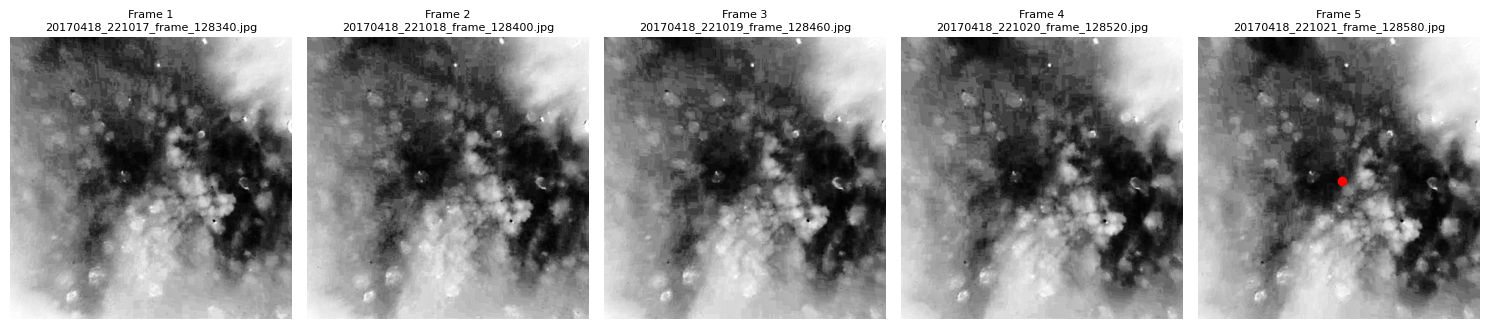

Sequence 2:
Normalized Flight Data:
  Step 1: {'GPS_MSL_Alt': 0.16644356, 'Drift': 0.78306246, 'Pitch': 0.30990553, 'Roll': 0.30990553, 'Vert_Velocity': 0.40037593}
  Step 2: {'GPS_MSL_Alt': 0.16666439, 'Drift': 0.78310436, 'Pitch': 0.31248212, 'Roll': 0.31248212, 'Vert_Velocity': 0.40131578}
  Step 3: {'GPS_MSL_Alt': 0.16688468, 'Drift': 0.7831617, 'Pitch': 0.31505868, 'Roll': 0.31505868, 'Vert_Velocity': 0.40601504}
  Step 4: {'GPS_MSL_Alt': 0.16710539, 'Drift': 0.7832193, 'Pitch': 0.31749213, 'Roll': 0.31749213, 'Vert_Velocity': 0.40977442}
  Step 5: {'GPS_MSL_Alt': 0.16732605, 'Drift': 0.7832612, 'Pitch': 0.31992558, 'Roll': 0.31992558, 'Vert_Velocity': 0.4107143}
Denormalized Flight Data:
  Step 1 (denormalized): {'GPS_MSL_Alt': 34.84000265718642, 'Drift': -87.82251162029607, 'Pitch': 19537.200002574922, 'Roll': 19537.200002574922, 'Vert_Velocity': 63649.99998033047}
  Step 2 (denormalized): {'GPS_MSL_Alt': 34.84161122682291, 'Drift': -87.82159335118902, 'Pitch': 19539.00000805855

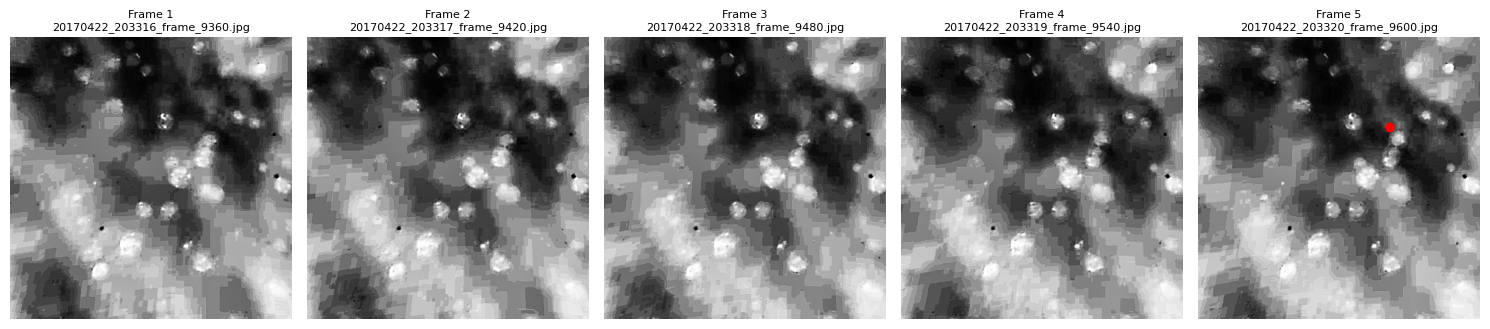

Sequence 3:
Normalized Flight Data:
  Step 1: {'GPS_MSL_Alt': 0.065979555, 'Drift': 0.7664295, 'Pitch': 0.5677068, 'Roll': 0.5677068, 'Vert_Velocity': 0.6033835}
  Step 2: {'GPS_MSL_Alt': 0.066062905, 'Drift': 0.7665354, 'Pitch': 0.56971085, 'Roll': 0.56971085, 'Vert_Velocity': 0.6043233}
  Step 3: {'GPS_MSL_Alt': 0.06615173, 'Drift': 0.7666266, 'Pitch': 0.57200116, 'Roll': 0.57200116, 'Vert_Velocity': 0.6080827}
  Step 4: {'GPS_MSL_Alt': 0.066245995, 'Drift': 0.76671875, 'Pitch': 0.5744346, 'Roll': 0.5744346, 'Vert_Velocity': 0.60902256}
  Step 5: {'GPS_MSL_Alt': 0.06634567, 'Drift': 0.76681197, 'Pitch': 0.57729745, 'Roll': 0.57729745, 'Vert_Velocity': 0.61466163}
Denormalized Flight Data:
  Step 1 (denormalized): {'GPS_MSL_Alt': 34.108220153578124, 'Drift': -88.18701743206091, 'Pitch': 19717.29998679161, 'Roll': 19717.29998679161, 'Vert_Velocity': 64190.00006079674}
  Step 2 (denormalized): {'GPS_MSL_Alt': 34.10882727464842, 'Drift': -88.18469628810182, 'Pitch': 19718.700000309946, '

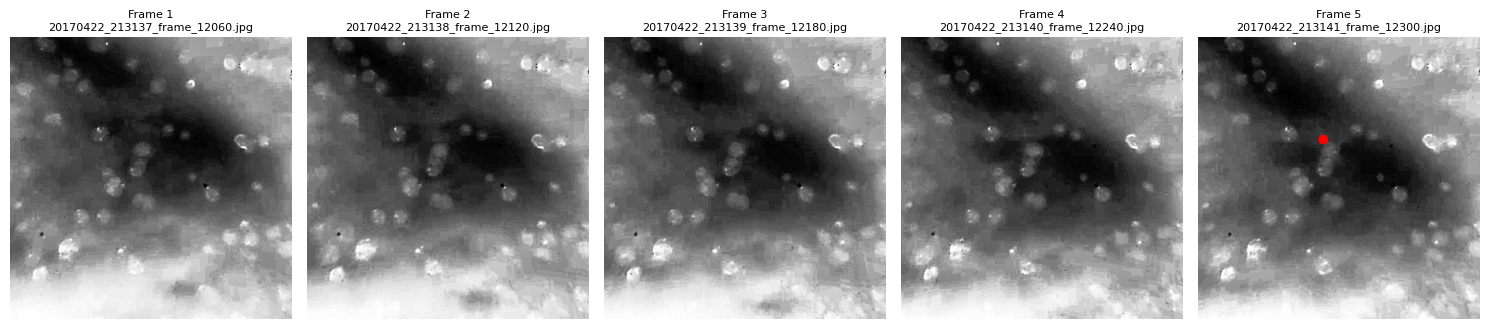

Sequence 4:
Normalized Flight Data:
  Step 1: {'GPS_MSL_Alt': 0.16323686, 'Drift': 0.82756466, 'Pitch': 0.8322359, 'Roll': 0.8322359, 'Vert_Velocity': 0.8599624}
  Step 2: {'GPS_MSL_Alt': 0.16323598, 'Drift': 0.8274647, 'Pitch': 0.8319496, 'Roll': 0.8319496, 'Vert_Velocity': 0.8580827}
  Step 3: {'GPS_MSL_Alt': 0.1632351, 'Drift': 0.8273647, 'Pitch': 0.8318065, 'Roll': 0.8318065, 'Vert_Velocity': 0.85902256}
  Step 4: {'GPS_MSL_Alt': 0.16323422, 'Drift': 0.8272647, 'Pitch': 0.8318065, 'Roll': 0.8318065, 'Vert_Velocity': 0.85902256}
  Step 5: {'GPS_MSL_Alt': 0.16323332, 'Drift': 0.82716477, 'Pitch': 0.83209276, 'Roll': 0.83209276, 'Vert_Velocity': 0.85902256}
Denormalized Flight Data:
  Step 1 (denormalized): {'GPS_MSL_Alt': 34.81664496699519, 'Drift': -86.84726149864514, 'Pitch': 19902.099980700015, 'Roll': 19902.099980700015, 'Vert_Velocity': 64872.499994039536}
  Step 2 (denormalized): {'GPS_MSL_Alt': 34.81663856310797, 'Drift': -86.84945202110964, 'Pitch': 19901.89998471737, 'Roll':

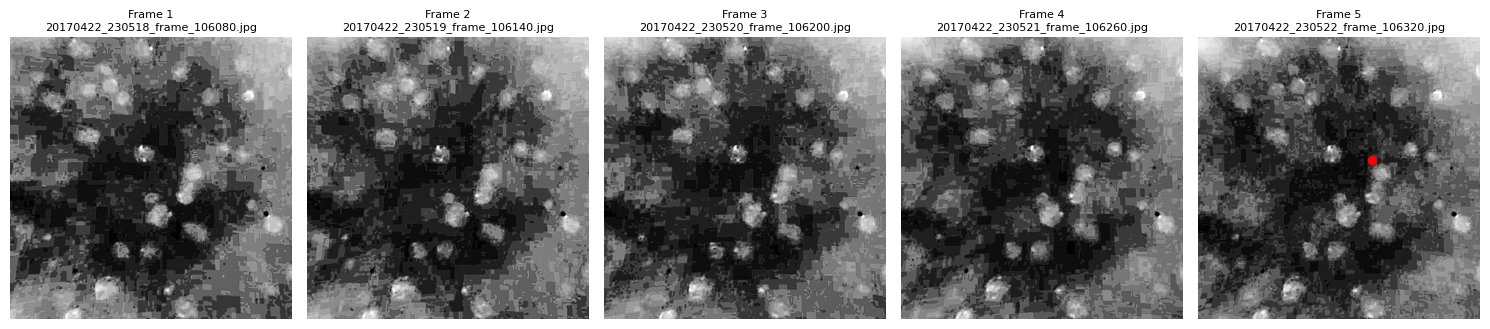

Sequence 5:
Normalized Flight Data:
  Step 1: {'GPS_MSL_Alt': 0.9690217, 'Drift': 0.02231081, 'Pitch': 0.32651016, 'Roll': 0.32622388, 'Vert_Velocity': 0.29699248}
  Step 2: {'GPS_MSL_Alt': 0.9687739, 'Drift': 0.022297813, 'Pitch': 0.3266533, 'Roll': 0.32651016, 'Vert_Velocity': 0.29605263}
  Step 3: {'GPS_MSL_Alt': 0.96852607, 'Drift': 0.022269161, 'Pitch': 0.32651016, 'Roll': 0.3266533, 'Vert_Velocity': 0.29605263}
  Step 4: {'GPS_MSL_Alt': 0.9682781, 'Drift': 0.02225618, 'Pitch': 0.32622388, 'Roll': 0.32651016, 'Vert_Velocity': 0.29605263}
  Step 5: {'GPS_MSL_Alt': 0.9677833, 'Drift': 0.022216326, 'Pitch': 0.325365, 'Roll': 0.32579446, 'Vert_Velocity': 0.2951128}
  Step 6: {'GPS_MSL_Alt': 0.96753514, 'Drift': 0.022202227, 'Pitch': 0.3246493, 'Roll': 0.325365, 'Vert_Velocity': 0.2932331}
  Step 7: {'GPS_MSL_Alt': 0.9670387, 'Drift': 0.022160698, 'Pitch': 0.3236473, 'Roll': 0.3240767, 'Vert_Velocity': 0.29135337}
  Step 8: {'GPS_MSL_Alt': 0.9665422, 'Drift': 0.022119192, 'Pitch': 0.32

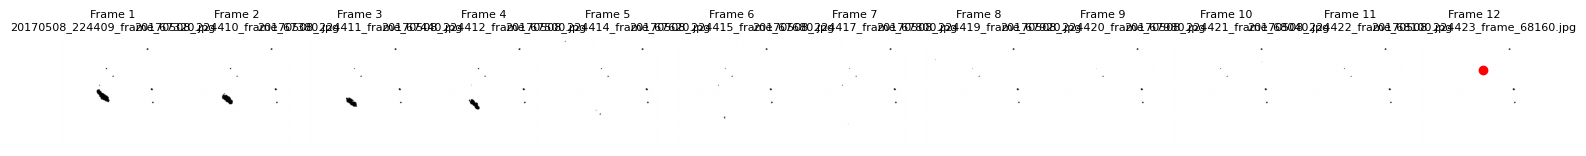

In [18]:
# Function to display a grid of images with a red dot at the revised center coordinates
def show_image_grid_with_center(images, center_coords, image_paths=None, titles=None):
    # Number of images in the sequence
    num_images = images.shape[0]

    # Set up the grid (1 row, num_images columns)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable even with one image

    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to HWC format
        img = np.clip(img, 0, 1)  # Ensure values are between 0 and 1 after normalization
        ax.imshow(img)

        # Only show red dot in last image
        if i == num_images - 1:
            center_x, center_y = center_coords
            ax.plot(center_x, center_y, 'ro')  # Red dot (marker 'ro' for red circle)

        ax.axis('off')

        # Set title using the same method as the other code
        if image_paths is not None:
            try:
                print(image_paths[i])
                path = os.path.basename(str(image_paths[i]))
                ax.set_title(f'Frame {i+1}\n{path}', fontsize=8)
            except (IndexError, TypeError):
                ax.set_title(f'Frame {i+1}')
        else:
            ax.set_title(f'Frame {i+1}')

    plt.tight_layout()
    plt.show()

# Iterate over the first 5 sequences for display with red dot on center
for i, (images, flight_data, validation_height, resized_center_coords, image_paths, timestamps) in enumerate(train_dataloader_single_batch):

    if i >= 5:  # Limiting to 5 sequences
        break

    # Display the image sequence
    print(f"Sequence {i + 1}:")

    # Display normalized flight data
    print("Normalized Flight Data:")
    flight_data_np = flight_data.squeeze(0).numpy()  # Convert tensor to NumPy for readability
    columns = ['GPS_MSL_Alt', 'Drift', 'Pitch', 'Roll', 'Vert_Velocity']

    for step, data in enumerate(flight_data_np):
        flight_info = dict(zip(columns, data))
        print(f"  Step {step + 1}: {flight_info}")

    # Denormalize and display flight data
    print("Denormalized Flight Data:")
    for step, data in enumerate(flight_data_np):
        denormalized_data = train_cloud2cloud_dataset.denormalize_flight_data(data)
        flight_info_denorm = dict(zip(columns, denormalized_data))
        print(f"  Step {step + 1} (denormalized): {flight_info_denorm}")

    # Display normalized validation height
    print("Normalized Validation Height:", validation_height.item())

    # Denormalize and display validation height
    validation_height_denorm = train_cloud2cloud_dataset.denormalize_validation_height(validation_height.item())
    print(f"Denormalized Validation Height: {validation_height_denorm:.2f} meters")

    # Unpack resized center coordinates (no need to squeeze since it's a list)
    resized_center_x, resized_center_y = resized_center_coords
    print(f"Resized Center Coordinates: (x: {resized_center_x}, y: {resized_center_y})")

    show_image_grid_with_center(
        images.squeeze(0),
        (resized_center_x, resized_center_y),
        image_paths=image_paths
    )

# CloudHeightEstimator Architecture

## Overview
The CloudHeightEstimator is a hybrid neural network architecture combining:
1. CNN for spatial feature extraction
2. Fully connected layers for flight data processing
3. LSTM for temporal dynamics
4. Attention mechanism for temporal weighting

Examining each step of the pipeline in detail:

# 1. Image Feature Extraction (facebook/convnext-large-384)

Each image in the sequence goes through:
- Input shape: $(B \times T \times 3 \times 384 \times 384)$
  - $B$: Batch size
  - $T$: Sequence length (2-5 frames)
  - 3: RGB channels
  - 384x384: Image dimensions

ConvNext processes each image through:
1. Series of convolutional blocks
2. Layer normalization
3. Global pooling
4. Output: Dense feature vector of dimension $D_{CNN}$

# 2. Flight Data Processing

Input: Normalized flight metadata $(B \times T \times D_{flight})$

Processing through fully connected layers:
1. First FC layer:
   - Input: $D_{flight}$ dimensions
   - Output: 128 dimensions
   - ReLU activation
2. Second FC layer:
   - Input: 128 dimensions
   - Output: 256 dimensions
   - No activation (linear)

This standardizes flight data features for combination with image features.

# 3. Combined Feature Processing

Concatenation operation:
1. Stack CNN features and flight data:
   - CNN features: $(B \times T \times D_{CNN})$
   - Flight features: $(B \times T \times 256)$
2. Result: $(B \times T \times (D_{CNN} + 256))$
3. This preserves temporal alignment between image and flight data

# 4. LSTM Processing

LSTM configuration:
1. Input: Combined features from previous step
2. Structure:
   - 2 LSTM layers
   - Hidden size = 256
   - Dropout between layers (0.3)
3. States:
   - Hidden state $(h_t)$: Carries processed information
   - Cell state $(c_t)$: Controls information flow
4. For each timestep:
   - Update gates control information flow
   - Process current input with previous states
   - Output new states

# 5. Attention Mechanism

Purpose: Weight the importance of different timesteps

Process:
1. Compute attention scores:
   - Linear transformation of LSTM outputs
   - Score for each timestep: $e_t = w^T h_t$
2. Mask padding:
   - Create binary mask based on sequence lengths
   - Set masked positions to negative infinity
3. Apply softmax:
   - Normalize scores to probabilities
   - $\alpha_t = \frac{\exp(e_t)}{\sum_j \exp(e_j)}$
4. Compute weighted sum:
   - Multiply each timestep by its attention weight
   - Sum across time dimension

# 6. Output Layer

Final processing:
1. Apply dropout (0.3) to attention output
2. Pass through final linear layer:
   - Input: Hidden dimension (256)
   - Output: Single value (cloud height)
3. Squeeze output to match target shape

The key feature of this architecture is how it combines:
- Spatial features (from images)
- Temporal features (from sequence)
- Metadata features (from flight data)

Each component solves a specific challenge:
- ConvNext: Extract cloud visual features
- Flight data FC: Process metadata
- LSTM: Capture temporal patterns
- Attention: Focus on most relevant timesteps
- Output: Combine all information for final prediction

## Architecture Components

### 1. Image Feature Extraction (ConvNext)
$$
\begin{align*}
& \text{Input: } I \in \mathbb{R}^{B \times T \times 3 \times 384 \times 384} \\
& \text{CNN: } f_{\text{CNN}}(I_t) \rightarrow \mathbb{R}^{D_{\text{CNN}}} \\
& \text{where: } \\
& \quad B = \text{batch size} \\
& \quad T = \text{sequence length} \\
& \quad D_{\text{CNN}} = \text{CNN feature dimension}
\end{align*}
$$

### 2. Flight Data Processing
$$
\begin{align*}
& \text{Input: } F \in \mathbb{R}^{B \times T \times D_{\text{flight}}} \\
& \text{FC Network: } f_{\text{FC}}(F) = \text{FC}_2(\text{ReLU}(\text{FC}_1(F))) \\
& \text{where: } \\
& \quad \text{FC}1: \mathbb{R}^{D{\text{flight}}} \rightarrow \mathbb{R}^{128} \\
& \quad \text{FC}_2: \mathbb{R}^{128} \rightarrow \mathbb{R}^{256}
\end{align*}
$$

### 3. Combined Feature Processing
$$
\begin{align*}
& \text{Combined Features: } X = [f_{\text{CNN}}(I), f_{\text{FC}}(F)] \\
& X \in \mathbb{R}^{B \times T \times (D_{\text{CNN}} + 256)}
\end{align*}
$$

### 4. LSTM Processing
$$
\begin{align*}
& \text{LSTM: } h_t = \text{LSTM}(X_t, h_{t-1}, c_{t-1}) \\
& \text{where: } \\
& \quad h_t \in \mathbb{R}^{B \times T \times D_{\text{hidden}}} \\
& \quad D_{\text{hidden}} = \text{hidden size} \\
& \quad \text{dropout} = 0.3
\end{align*}
$$

### 5. Attention Mechanism
$$
\begin{align*}
& \text{Attention Scores: } e_t = w^T h_t \\
& \text{Masked Attention: } \tilde{e}t = \begin{cases}
e_t & \text{if } t \leq \text{sequence_length} \\
-\infty & \text{otherwise}
\end{cases} \\
& \text{Attention Weights: } \alpha = \text{softmax}(\tilde{e}) \\
& \text{Context Vector: } c = \sum{t=1}^T \alpha_t h_t
\end{align*}
$$

### 6. Output Layer
$$
\begin{align*}
& \text{Dropout: } c_{\text{drop}} = \text{dropout}(c, p=0.3) \\
& \text{Final Output: } y = \text{FC}{\text{out}}(c{\text{drop}}) \\
& y \in \mathbb{R}^B \text{ (predicted cloud heights)}
\end{align*}
$$

## Data Flow Sequence

1. Input Processing:

    $$\text{Images} \xrightarrow{\text{ConvNext}} \text{Image Features}$$
    $$\text{Flight Data} \xrightarrow{\text{FC Network}} \text{Processed Flight Data}$$

2. Feature Combination:

   $$[\text{Image Features}, \text{Processed Flight Data}] \rightarrow \text{Combined Features}$$

3. Temporal Processing:
   $$\text{Combined Features} \xrightarrow{\text{LSTM}} \text{Hidden States}$$

4. Attention and Output:
   $$\text{Hidden States} \xrightarrow{\text{Attention}} \text{Context} \xrightarrow{\text{FC}} \text{Height Prediction}$$


In [19]:
%%html
<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 1000 600">
    <!-- Input Layer -->
    <g transform="translate(50,50)">
        <!-- Image Input -->
        <rect x="0" y="0" width="120" height="80" fill="none" stroke="#1f77b4" stroke-width="2"/>
        <text x="60" y="45" text-anchor="middle" font-family="Arial">Image Sequence</text>
        <text x="60" y="65" text-anchor="middle" font-family="Arial" font-size="10">BxTx3x384x384</text>

        <!-- Flight Data Input -->
        <rect x="0" y="120" width="120" height="80" fill="none" stroke="#1f77b4" stroke-width="2"/>
        <text x="60" y="165" text-anchor="middle" font-family="Arial">Flight Data</text>
        <text x="60" y="185" text-anchor="middle" font-family="Arial" font-size="10">BxTxD_flight</text>
    </g>

    <!-- First Processing Stage -->
    <g transform="translate(250,50)">
        <!-- ConvNext -->
        <rect x="0" y="0" width="120" height="80" fill="none" stroke="#2ca02c" stroke-width="2"/>
        <text x="60" y="45" text-anchor="middle" font-family="Arial">ConvNext</text>
        <text x="60" y="65" text-anchor="middle" font-family="Arial" font-size="10">D_CNN</text>

        <!-- FC Network -->
        <rect x="0" y="120" width="120" height="80" fill="none" stroke="#2ca02c" stroke-width="2"/>
        <text x="60" y="165" text-anchor="middle" font-family="Arial">FC Network</text>
        <text x="60" y="185" text-anchor="middle" font-family="Arial" font-size="10">256</text>
    </g>

    <!-- Feature Concatenation -->
    <g transform="translate(450,85)">
        <rect x="0" y="0" width="140" height="80" fill="none" stroke="#ff7f0e" stroke-width="2"/>
        <text x="70" y="45" text-anchor="middle" font-family="Arial">Concatenated</text>
        <text x="70" y="65" text-anchor="middle" font-family="Arial" font-size="10">BxTx(D_CNN + 256)</text>
    </g>

    <!-- LSTM -->
    <g transform="translate(670,85)">
        <rect x="0" y="0" width="120" height="80" fill="none" stroke="#d62728" stroke-width="2"/>
        <text x="60" y="45" text-anchor="middle" font-family="Arial">LSTM</text>
        <text x="60" y="65" text-anchor="middle" font-family="Arial" font-size="10">D_hidden</text>
    </g>

    <!-- Attention -->
    <g transform="translate(670,220)">
        <rect x="0" y="0" width="120" height="80" fill="none" stroke="#9467bd" stroke-width="2"/>
        <text x="60" y="45" text-anchor="middle" font-family="Arial">Attention</text>
        <text x="60" y="65" text-anchor="middle" font-family="Arial" font-size="10">α_t weights</text>
    </g>

    <!-- Output -->
    <g transform="translate(870,150)">
        <rect x="0" y="0" width="100" height="60" fill="none" stroke="#8c564b" stroke-width="2"/>
        <text x="50" y="35" text-anchor="middle" font-family="Arial">Height</text>
    </g>

    <!-- Arrows -->
    <!-- Image to ConvNext -->
    <path d="M 170,90 L 250,90" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
    <!-- Flight Data to FC -->
    <path d="M 170,160 L 250,160" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
    <!-- ConvNext to Concat -->
    <path d="M 370,90 L 450,125" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
    <!-- FC to Concat -->
    <path d="M 370,160 L 450,125" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
    <!-- Concat to LSTM -->
    <path d="M 590,125 L 670,125" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
    <!-- LSTM to Attention -->
    <path d="M 730,165 L 730,220" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>
    <!-- Attention to Output -->
    <path d="M 790,260 L 870,180" stroke="black" stroke-width="2" marker-end="url(#arrowhead)"/>

    <!-- Arrowhead definition -->
    <defs>
        <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="9" refY="3.5" orient="auto">
            <polygon points="0 0, 10 3.5, 0 7" fill="black"/>
        </marker>
    </defs>
</svg>

# CNN-RNN CloudHeightEstimator Model

In [20]:
class CloudHeightEstimator(nn.Module):
    def __init__(self, cnn_model_name, rnn_input_size, rnn_hidden_size, rnn_num_layers, flight_data_size):
        super(CloudHeightEstimator, self).__init__()

        # Store rnn_num_layers and rnn_hidden_size as class attributes
        self.rnn_num_layers = rnn_num_layers
        self.rnn_hidden_size = rnn_hidden_size

        # Load ConvNext as feature extractor (CNN part)
        self.cnn = ConvNextModel.from_pretrained(cnn_model_name)
        self.cnn_feature_dim = self.cnn.config.hidden_sizes[-1]

        # Fully connected network for flight data processing
        self.fc_flight = nn.Sequential(
            nn.Linear(flight_data_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256)
        )

        # Define RNN to capture temporal dynamics with increased capacity
        self.rnn = nn.LSTM(input_size=self.cnn_feature_dim + 256,  # Flight data processed to 256
                           hidden_size=rnn_hidden_size,
                           num_layers=rnn_num_layers,
                           batch_first=True,
                           dropout=0.3)  # Dropout between RNN layers

        # Attention mechanism to focus on important time steps
        self.attention = nn.Linear(rnn_hidden_size, 1)

        # Fully connected layer to output the predicted center height
        self.fc_out = nn.Linear(rnn_hidden_size, 1)

        self.dropout = nn.Dropout(0.3)  # Dropout to avoid overfitting

    def forward(self, batch):
        # Handle None batch case
        if batch is None:
            return None

        # Unpack sequences while maintaining padding
        images, _ = pad_packed_sequence(batch['images'], batch_first=True)
        flight_data, _ = pad_packed_sequence(batch['metadata'], batch_first=True)
        sequence_lengths = batch['sequence_lengths']

        batch_size = images.size(0)
        seq_len = images.size(1)

        # Reset the RNN hidden state
        h_0 = torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size).to(images.device)
        c_0 = torch.zeros(self.rnn_num_layers, batch_size, self.rnn_hidden_size).to(images.device)

        # Extract spatial features from each image in the sequence using ConvNext
        features = []
        for t in range(seq_len):
            cnn_out = self.cnn(images[:, t, :, :, :]).pooler_output
            features.append(cnn_out)

        features = torch.stack(features, dim=1)

        # Process flight data
        flight_data_processed = self.fc_flight(flight_data)

        # Concatenate flight data to CNN features
        rnn_input = torch.cat((features, flight_data_processed), dim=2)

        # Create packed sequence for RNN using original batch sizes
        packed_features = PackedSequence(
            rnn_input.reshape(-1, rnn_input.size(-1)),
            batch['images'].batch_sizes,
            batch['images'].sorted_indices,
            batch['images'].unsorted_indices
        )

        # Pass through RNN
        rnn_out, _ = self.rnn(packed_features, (h_0, c_0))

        # Unpack RNN output
        rnn_out, _ = pad_packed_sequence(rnn_out, batch_first=True)

        # Create attention mask based on sequence lengths
        attention_mask = torch.arange(seq_len, device=images.device)[None, :] >= sequence_lengths[:, None]

        # Compute attention weights (mask out padding)
        attention_weights = self.attention(rnn_out).squeeze(-1)
        attention_weights = attention_weights.masked_fill(attention_mask, float('-inf'))
        attention_weights = F.softmax(attention_weights, dim=1)

        # Apply attention
        weighted_rnn_out = (rnn_out * attention_weights.unsqueeze(-1)).sum(dim=1)

        # Apply dropout
        weighted_rnn_out = self.dropout(weighted_rnn_out)

        # Output the predicted center height
        center_height = self.fc_out(weighted_rnn_out).squeeze(-1)

        return center_height

# Model Initialization and Training Configuration

## 1. Base Model Selection
```
model_name = "facebook/convnext-large-384"
```
Significance:
- Pre-trained on ImageNet
- Optimized for 384x384 input size
- 'Large' variant offers higher capacity
- Matches our preprocessed image dimensions

## 2. Model Architecture Dimensions

### CNN Features
ConvNext-large output dimension: 1536
- Determined by model architecture
- Fixed by pre-trained weights

### RNN Configuration
```
rnn_input_size = 1536 + 256  # Combined features
rnn_hidden_size = 256        # State dimension
rnn_num_layers = 2          # Stacked LSTM layers
```

### Flight Data
```python
flight_data_size = len(metadata_manager.flight_data)
```
- Dynamic based on available flight parameters set by the FlightMetadataManager class. Any changes to that class will automatically be reflected here.
- Includes all normalized flight metrics

## 3. Training Parameters

### Hardware Optimization
```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```
- Automatic GPU detection
- Falls back to CPU if needed

### Hyperparameters
1. **Learning Rate**: $1e^{-4}$
   - Relatively small for fine-tuning
   - Prevents catastrophic forgetting of pre-trained features

2. **Batch Size**: 4
   - Limited by GPU memory
   - Balanced between:
     * Training stability
     * Memory constraints
     * Processing efficiency

3. **Weight Decay**: 0.01
   - L2 regularization
   - Prevents overfitting
   - Common value for AdamW

## 4. Loss Function

Huber Loss (Smooth L1):
$$
L_{\delta}(y, \hat{y}) = \begin{cases}
\frac{1}{2}(y - \hat{y})^2 & \text{for } |y - \hat{y}| \leq \delta \\
\delta|y - \hat{y}| - \frac{1}{2}\delta^2 & \text{otherwise}
\end{cases}
$$

Benefits:
- Robust to outliers
- Combines MSE and MAE advantages
- Delta = 1.0 balances:
  * Quadratic behavior near zero
  * Linear behavior for large errors

## 5. Optimizer Configuration

### AdamW
- Adam variant with decoupled weight decay
- Better generalization than standard Adam
- Parameters:
  * Learning rate: $1e^{-4}$
  * Weight decay: 0.01

### Learning Rate Scheduler
```python
ReduceLROnPlateau(
    mode='min',
    factor=0.5,
    patience=2,
    min_lr=1e-7
)
```

Operation:
1. Monitors validation loss
2. If no improvement for 2 epochs:
   - Reduces learning rate by half
3. Won't go below $1e^{-7}$
4. Helps navigate loss landscape

Flow:
$$\text{lr}_{\text{new}} = \max(\text{lr}_{\text{current}} \times 0.5, 1e^{-7})$$

This initialization strategy balances:
- Model capacity
- Training stability
- Convergence speed
- Memory efficiency
- Generalization ability

In [21]:
# Initialize model, dataset, and training parameters
model_name = "facebook/convnext-large-384"

# Initialize model with correct dimensions
model = CloudHeightEstimator(
    cnn_model_name=model_name,
    rnn_input_size=1536 + 256,  # ConvNext-large output + processed flight data
    rnn_hidden_size=256,  # Reduced from 512
    rnn_num_layers=2,
    flight_data_size=len(train_cloud2cloud_dataset.metadata_manager.flight_data)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Hyperparameters
learning_rate = 1e-4
num_epochs = 10
batch_size = 4

# Loss function and optimizer
def huber_loss(pred, target, delta=1.0):
    loss = F.smooth_l1_loss(pred, target, reduction='none', beta=delta)
    return loss.mean()

# Loss function and optimizer
criterion = huber_loss
optimizer = optim.AdamW(  # Switch to AdamW
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.01  # Add weight decay
)

# Add a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True,
    min_lr=1e-7
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

# Sequence Collation and Packing

## Purpose of Collation
When batching sequences for training, we need to handle:
1. Variable-length sequences (2-5 frames)
2. Missing/invalid data
3. Multiple aligned data streams (images, flight data, timestamps)
4. Memory efficiency
5. RNN processing requirements

## Process Breakdown

### 1. Initial Data Unpacking
```
Input Batch Structure:
- image_sequences: (B × T × C × H × W)
- flight_data_list: (B × T × D_flight)
- validation_heights: (B × 1)
- resized_center_coords: (B × 2)
- image_paths: (B × T)
- timestamp_sequences: (B × T)
```

### 2. Sequence Validation and Truncation
For each sequence:

$$
\begin{align*}
& \text{Valid Index Set} = {i : \text{GPS_MSL_Alt}_i \neq \text{NaN}} \\
& \text{last_valid_idx} = \max(\text{Valid Index Set}) \\
& \text{start_idx} = \max(0, \text{last_valid_idx} - \text{max_sequence_length} + 1) \\
& \text{sequence_length} = \min(\text{end_idx} - \text{start_idx}, \text{max_sequence_length})
\end{align*}
$$

### 3. Sequence Length Requirements
```
Constraints:
2 ≤ sequence_length ≤ 5
```

Motivation:
- Minimum 2 frames needed for temporal patterns
- Maximum 5 frames for computational efficiency
- Must have valid GPS altitude data

### 4. Sequence Sorting and Packing

#### Why Pack Sequences?
1. **Memory Efficiency**
   - No need to pad all sequences to maximum length
   - Only stores actual data points

2. **Computational Efficiency**
   - RNN computations only on valid timesteps
   - Avoids processing padding tokens

3. **Better Gradient Flow**
   - No gradients through padding
   - More stable training

#### Packing Process:
1. Sort by length (descending):
   $$\text{sequences} = \text{sort}(\text{sequences}, \text{key}=\text{len}, \text{reverse}=\text{True})$$

2. Pack sequences:
   ```
   PackedSequence Structure:
   - data: All sequence elements concatenated
   - batch_sizes: Number of sequences at each timestep
   - sorted_indices: Original sorting order
   - unsorted_indices: Restore original order
   ```

Example:
```
Original Sequences:
Seq1: [A1, A2, A3]
Seq2: [B1, B2]
Seq3: [C1, C2, C3, C4]

Sorted:
C1, C2, C3, C4
A1, A2, A3, --
B1, B2, --, --

Packed:
data: [C1, A1, B1, C2, A2, B2, C3, A3, C4]
batch_sizes: [3, 3, 2, 1]
```

### 5. Final Output Structure
```python
{
    'images': PackedSequence,      # Packed image sequences
    'metadata': PackedSequence,    # Packed flight data
    'validation_height': Tensor,   # Single height per sequence
    'center_coords': Tensor,       # Coordinate pairs
    'sequence_lengths': Tensor,    # Length of each sequence
    'image_paths': List,          # For debugging/visualization
    'timestamps': List            # Temporal alignment
}
```

This structure ensures:
1. Memory efficient storage
2. Aligned multimodal data
3. Efficient RNN processing
4. Easy access to metadata
5. Debugging capability

# Sequence Truncation Strategy

## Problem Statement
Two main issues with sequence lengths:
1. **Memory Issues**
   - Long sequences (5+ frames) cause Out-of-Memory (OOM) errors
   - Each image is 384x384x3, consuming significant GPU memory when batched

2. **Data Quality Issues**
   - Some sequences are abnormally long (1000+ frames)
   - Usually indicates data collection or synchronization problems
   - Can be caused by:
     * Missing LiDAR measurements
     * GPS data gaps
     * Timestamp misalignment

## Truncation Implementation

### 1. Valid Data Detection
```
For each sequence:
1. Check GPS_MSL_Alt for NaN values
2. Find last valid index where data exists
3. If no valid data found, skip sequence
```

### 2. Sequence Windowing
```
start_idx = max(0, last_valid_idx - max_sequence_length + 1)
end_idx = last_valid_idx + 1
```

Key points:
- Always keeps the most recent valid frames
- Works backward from last valid measurement
- Ensures LiDAR measurement aligns with final frame

### 3. Length Constraints
```
min_sequence_length = 2  # Minimum for temporal patterns
max_sequence_length = 5  # Maximum for memory management
```

Benefits:
- Prevents OOM errors
- Ensures consistent batch sizes
- Maintains temporal coherence
- Filters out problematic sequences

## Example Scenarios

1. **Normal Case**:
   ```
   Original: [F1, F2, F3, F4, F5, F6, F7, F8]  // 8 frames
   Last valid: F8
   Truncated: [F4, F5, F6, F7, F8]  // 5 frames
   ```

2. **Bad Data Case**:
   ```
   Original: [F1, F2, ..., F1000]  // 1000 frames
   Last valid: F1000
   Truncated: [F996, F997, F998, F999, F1000]  // 5 frames
   ```

3. **Short Sequence**:
   ```
   Original: [F1, F2, F3]  // 3 frames
   Last valid: F3
   Result: [F1, F2, F3]  // Kept as is
   ```

4. **Invalid Sequence**:
   ```
   Original: [F1(NaN), F2(NaN), F3(NaN)]  // All invalid
   Result: Sequence discarded
   ```

This truncation strategy effectively:
- Manages memory usage
- Maintains data quality
- Preserves temporal relationships
- Handles edge cases gracefully

In [22]:
def collate_fn(batch, max_sequence_length=5, min_sequence_length=2):
    """
    Collate function using packed sequences while maintaining alignment between
    images and metadata. Filters out sequences shorter than min_sequence_length.
    validation_height and center_coords remain as single values per sequence.
    timestamps are handled separately.
    """
    metadata_manager = FlightMetadataManager()

    # Unpack with timestamps
    image_sequences, flight_data_list, validation_heights, resized_center_coords_list, image_paths_list, timestamp_sequences = zip(*batch)

    # Truncate sequences, keeping the most recent valid frames
    truncated_sequences = []  # Will store tuples of (images, flight_data, image_paths, timestamps)
    sequence_lengths = []
    valid_indices = []  # Track which sequences we're keeping

    for idx, (imgs, flight_data, image_paths, timestamps) in enumerate(zip(image_sequences, flight_data_list, image_paths_list, timestamp_sequences)):
        # Find last valid index (non-NaN in metadata)
        valid_metadata_indices = torch.where(~torch.isnan(flight_data[:, metadata_manager.get_index('GPS_MSL_Alt')]))[0]
        if len(valid_metadata_indices) == 0:
            last_valid_idx = -1
        else:
            last_valid_idx = valid_metadata_indices[-1].item()

        # Truncate to last max_sequence_length valid frames
        start_idx = max(0, last_valid_idx - max_sequence_length + 1)
        end_idx = last_valid_idx + 1

        # Only include sequences that meet the minimum length requirement
        sequence_length = min(end_idx - start_idx, max_sequence_length)
        if sequence_length >= min_sequence_length:
            # Store truncated sequences together to maintain alignment
            truncated_sequences.append((
                imgs[start_idx:end_idx],
                flight_data[start_idx:end_idx],
                image_paths[start_idx:end_idx],
                timestamps[start_idx:end_idx]  # Add timestamps
            ))
            sequence_lengths.append(sequence_length)
            valid_indices.append(idx)

    # If no valid sequences, return None or raise an error
    if not truncated_sequences:
        return None  # Or raise ValueError("No sequences meet the minimum length requirement")

    # Sort by length in descending order
    sorted_indices = np.argsort(sequence_lengths)[::-1]
    sequence_lengths = [sequence_lengths[i] for i in sorted_indices]
    truncated_sequences = [truncated_sequences[i] for i in sorted_indices]
    # Only include validation heights and center coords for valid sequences
    validation_heights = [validation_heights[valid_indices[i]] for i in sorted_indices]
    resized_center_coords = [resized_center_coords_list[valid_indices[i]] for i in sorted_indices]

    # Separate aligned sequences
    sorted_images, sorted_flight_data, sorted_image_paths, sorted_timestamps = zip(*truncated_sequences)

    # Pack sequences
    packed_images = pack_sequence([seq for seq in sorted_images])
    packed_metadata = pack_sequence([torch.as_tensor(data, dtype=torch.float32)
                                   for data in sorted_flight_data])

    return {
        'images': packed_images,
        'metadata': packed_metadata,
        'validation_height': torch.as_tensor(validation_heights, dtype=torch.float32),
        'center_coords': torch.as_tensor(resized_center_coords, dtype=torch.long),
        'sequence_lengths': torch.tensor(sequence_lengths),
        'image_paths': sorted_image_paths,
        'timestamps': sorted_timestamps  # Add timestamps to output
    }

# Wrapper method to add extra features to the collate function as well as filter out sequences that are too short
def filter_collate_fn(batch):
    collated = collate_fn(batch, max_sequence_length=5, min_sequence_length=2)
    if collated is None:
        print("Skipping batch with no valid sequences")
        return None
    return collated

train_dataloader = DataLoader(train_cloud2cloud_dataset, batch_size=batch_size, shuffle=True, collate_fn=filter_collate_fn)
val_dataloader = DataLoader(val_cloud2cloud_dataset, batch_size=batch_size, shuffle=False, collate_fn=filter_collate_fn)

# Initialize arrays to track training and validation losses
train_loss_values = []
val_loss_values = []

# Training Loop

## 1. Data Movement and Error Handling

### Device Management
```python
def move_batch_to_device(batch, device):
```
Handles three types of data:
1. PyTorch Tensors: Direct device transfer
2. PackedSequences: Special handling for RNN inputs
   - Moves data while preserving sequence information
   - Maintains batch sizes and indices
3. Non-tensor data: Passed through unchanged

### Training Batch Processing
```python
def train_batch(model, batch, optimizer, criterion, device, clip_value=1.0):
```

Error checking sequence:
1. Null batch validation
2. Shape consistency checks
3. NaN detection points:
   - Predictions
   - Targets
   - Loss values
   - Gradients

## 2. Main Training Loop

### Epoch Structure
For each epoch:

1. **Training Phase**
   ```
   Initialize:
   - running_loss = 0.0
   - valid_batches = 0
   ```

   For each batch:
   1. Process batch
   2. Accumulate loss if valid
   3. Log every 10 batches

2. **Validation Phase**
   ```
   Initialize:
   - val_running_loss = 0.0
   - valid_val_batches = 0
   ```

   With gradient computation disabled:
   1. Process validation batch
   2. Accumulate loss if valid
   3. Update learning rate scheduler

## 3. Gradient Flow

Training sequence:
```
1. optimizer.zero_grad()
2. Forward pass → predicted_center_height
3. Loss computation
4. loss.backward()
5. Gradient clipping (max_norm=1.0)
6. optimizer.step()
```

## 4. Loss Handling

### Training Loss
$$
L_{\text{train}} = \begin{cases}
\frac{\sum \text{batch_losses}}{\text{valid_batches}} & \text{if valid_batches > 0} \
\text{break training} & \text{otherwise}
\end{cases}
$$

### Validation Loss
$$
L_{\text{val}} = \begin{cases}
\frac{\sum \text{val_batch_losses}}{\text{valid_val_batches}} & \text{if valid_val_batches > 0} \
\text{break training} & \text{otherwise}
\end{cases}
$$

## 5. Learning Rate Scheduling

After each epoch:
```
if valid_val_batches > 0:
    scheduler.step(avg_val_loss)
```

Learning rate adjustment:
$$
\text{lr}_{\text{new}} = \begin{cases}
\text{lr}_{\text{current}} \times 0.5 & \text{if no improvement for 2 epochs} \\
\text{lr}_{\text{current}} & \text{otherwise}
\end{cases}
$$

## 6. Monitoring and Visualization

1. Per-batch logging:
   - Every 10 batches
   - Current loss value
   - Progress indicators

2. Per-epoch metrics:
   - Average training loss
   - Average validation loss
   - Learning rate changes

3. Final visualization:
   - Training vs Validation loss plot
   - Epoch progression
   - Loss trends

This training loop implements:
- Robust error handling
- Device management
- Gradient flow control
- Dynamic learning rate adjustment
- Progress monitoring

In [23]:
def move_batch_to_device(batch, device):
    """Helper function to move all tensors in a batch to device"""
    if batch is None:
        return None

    moved_batch = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            moved_batch[key] = value.to(device)
        elif isinstance(value, PackedSequence):
            # Move the PackedSequence data to device
            moved_batch[key] = PackedSequence(
                value.data.to(device),
                value.batch_sizes,
                value.sorted_indices,
                value.unsorted_indices
            )
        else:
            # For non-tensor data (like lists or strings)
            moved_batch[key] = value
    return moved_batch

def train_batch(model, batch, optimizer, criterion, device, clip_value=1.0):
    """Process a single training batch with error checking"""
    if batch is None:
        return None

    # Move batch to device
    batch = move_batch_to_device(batch, device)

    optimizer.zero_grad()

    # Forward pass
    predicted_center_height = model(batch)
    validation_height = batch['validation_height']

    # Validate outputs
    if predicted_center_height is None:
        print("Model returned None")
        return None
    if predicted_center_height.shape != validation_height.shape:
        print(f"Shape mismatch: pred {predicted_center_height.shape} vs target {validation_height.shape}")
        return None

    # Check for invalid values before loss
    if torch.any(torch.isnan(predicted_center_height)):
        print("NaN in predictions")
        return None
    if torch.any(torch.isnan(validation_height)):
        print("NaN in targets")
        return None

    # Compute loss
    try:
        loss = criterion(predicted_center_height, validation_height)
    except Exception as e:
        print(f"Error computing loss: {e}")
        return None

    if torch.isnan(loss):
        print("NaN loss detected")
        return None

    # Backward pass with gradient clipping
    loss.backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
    if torch.isnan(grad_norm):
        print("NaN gradient detected")
        return None

    optimizer.step()

    return loss.item()

if train_model == True:
  # Training loop
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      valid_batches = 0

      # Training phase
      for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
          loss = train_batch(model, batch, optimizer, criterion, device)

          if loss is not None:
              running_loss += loss
              valid_batches += 1

              if i % 10 == 0:
                  print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {loss:.4f}")

      # Compute average loss only for valid batches
      if valid_batches > 0:
          avg_train_loss = running_loss / valid_batches
          train_loss_values.append(avg_train_loss)
          print(f"Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}")
      else:
          print("No valid batches in epoch")
          break

      # Validation phase
      model.eval()
      val_running_loss = 0.0
      valid_val_batches = 0

      with torch.no_grad():
          for batch in tqdm(val_dataloader, desc="Validation"):
              if batch is None:
                  continue

              batch = move_batch_to_device(batch, device)
              predicted_center_height = model(batch)

              if predicted_center_height is None:
                  continue

              val_loss = criterion(predicted_center_height, batch['validation_height'])

              if not torch.isnan(val_loss):
                  val_running_loss += val_loss.item()
                  valid_val_batches += 1

      if valid_val_batches > 0:
          avg_val_loss = val_running_loss / valid_val_batches
          val_loss_values.append(avg_val_loss)
          print(f"Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}")
          scheduler.step(avg_val_loss)
      else:
          print("No valid validation batches")
          break

  # Plot training and validation losses
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o', label='Training Loss')
  plt.plot(range(1, num_epochs + 1), val_loss_values, marker='o', label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.grid()
  plt.legend()
  plt.show()

  print("Training complete.")

In [24]:
def load_checkpoint(model, optimizer, path):
    # Load the checkpoint
    checkpoint = torch.load(path)

    # Restore the model and optimizer state dictionaries
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract other saved details
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']

    # Return the restored state
    return model, optimizer, epoch, train_loss, val_loss


if train_model == False :
  checkpoint_path = '/content/drive/My Drive/cloud_height_model_checkpoint.pth'
  model, optimizer, epoch, train_loss, val_loss = load_checkpoint(model, optimizer, checkpoint_path)

<ipython-input-24-03e9519549f3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


# Denormalizing Huber Loss

## The Challenge

When we train the model, we're working with normalized cloud heights:
- Original heights: typically 8,000m - 14,000m
- Normalized to range [0,1]

The Huber loss we get during training is based on these normalized values, which makes the loss values very small and hard to interpret. We want to convert these losses back to meaningful meters for easier human understanding.

## Why Approximation is Needed

The Huber loss function has two regions:
1. Quadratic region (for small errors): $\frac{1}{2}(y - \hat{y})^2$ when $|y - \hat{y}| \leq \delta$
2. Linear region (for large errors): $\delta|y - \hat{y}| - \frac{1}{2}\delta^2$ when $|y - \hat{y}| > \delta$

Because of this piecewise nature, we can't perfectly denormalize the loss. Consider:
```
Original heights: 8000m to 14000m (range = 6000m)
Normalized heights: 0 to 1 (range = 1)

If normalized error = 0.1:
- Could be 600m in real units (0.1 × 6000)
- But Huber loss doesn't scale linearly
```

## Our Approximation

We use a simple scaling approach:
```python
denormalized_loss = normalized_loss * height_range
```

This gives us an approximate error in meters that:
- Preserves relative relationships between losses
- Provides rough magnitude of prediction errors
- Helps interpret model performance

## Example:
```
height_range = 14000m - 8000m = 6000m
normalized_loss = 0.01

denormalized_loss = 0.01 * 6000 = 60m
```

This tells us our model's predictions are off by approximately 60 meters on average.

## Limitations

This approximation:
1. Doesn't perfectly capture the non-linear parts of Huber loss
2. May overestimate or underestimate real errors
3. Should be used as a rough guide rather than exact error

However, it's valuable for:
- Monitoring training progress
- Comparing model versions
- Understanding model performance in real units
- Communication with stakeholders

In [25]:
def denormalize_loss(loss_values, dataset):
    """
    Denormalize Huber loss values by scaling them with the dataset's normalization range.
    """
    denormalized_losses = []
    for loss in loss_values:
        # Get the normalization range for heights
        height_min = dataset.normalization_params['validation_height']['min']
        height_max = dataset.normalization_params['validation_height']['max']
        height_range = height_max - height_min

        # Scale the loss by the range of the target variable
        denormalized_loss = loss * height_range
        denormalized_losses.append(denormalized_loss)
    return denormalized_losses

if train_model == True:

  # Denormalize both training and validation loss values
  denorm_train_loss_values = denormalize_loss(train_loss_values, train_cloud2cloud_dataset)
  denorm_val_loss_values = denormalize_loss(val_loss_values, train_cloud2cloud_dataset)

  # Plot the denormalized training and validation loss values
  plt.figure(figsize=(10, 5))
  plt.plot(range(1, num_epochs + 1), denorm_train_loss_values, marker='o', label='Denormalized Training Loss')
  plt.plot(range(1, num_epochs + 1), denorm_val_loss_values, marker='o', label='Denormalized Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Approximate Error (m)')
  plt.title('Scaled Training and Validation Loss Over Epochs')
  plt.grid()
  plt.legend()
  plt.show()

In [26]:
# Function to display 5 random examples from the dataset
def display_random_examples(dataset, model, device):
    random_indices = random.sample(range(len(dataset)), 10)
    examples = []

    for idx in random_indices:
        # Get the data for the current index
        data = dataset[idx]

        # Unpack the values from the data
        image_sequence, flight_data, normalized_validation_height, resized_center_coords, image_paths, timestamps = data

        print(f"Sequence {idx}:")
        print(f"  Validation Height before denormalization: {normalized_validation_height.item()} meters")
        print(f"  Validation Height = {dataset.denormalize_validation_height(normalized_validation_height.item()):.2f} meters")

        # Create a single-item batch with packed sequences
        image_sequence = image_sequence.unsqueeze(0).to(device)
        flight_data = flight_data.clone().detach().unsqueeze(0).to(device)

        sequence_lengths = torch.tensor([image_sequence.shape[1]], dtype=torch.int64).to(device)

        # Pack the sequences
        # 1. Move sequence_lengths to CPU temporarily
        sequence_lengths_cpu = sequence_lengths.cpu()
        packed_images = pack_padded_sequence(image_sequence, sequence_lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_flight_data = pack_padded_sequence(flight_data, sequence_lengths_cpu, batch_first=True, enforce_sorted=False)

        # 2. Move packed sequences back to the original device (GPU)
        packed_images = packed_images.to(device)
        packed_flight_data = packed_flight_data.to(device)

        # Corrected dictionary keys to match forward() function expectations
        single_item_batch = {
            'images': packed_images,
            'metadata': packed_flight_data,
            'sequence_lengths': sequence_lengths,
        }

        # Run the model to predict the center height
        with torch.no_grad():
            predicted_center_height = model(single_item_batch)
            predicted_center_height = predicted_center_height.squeeze().cpu().item()  # Convert to scalar

        # De-normalize the predicted center height and validation height
        predicted_center_height_denorm = dataset.denormalize_validation_height(predicted_center_height)
        validation_height_denorm = dataset.denormalize_validation_height(normalized_validation_height)

        # Calculate MSE (Mean Squared Error)
        mse = (predicted_center_height_denorm - validation_height_denorm) ** 2

        # Calculate MAPE (Mean Absolute Percentage Error)
        if validation_height_denorm != 0:
            mape = (abs(predicted_center_height_denorm - validation_height_denorm) / abs(validation_height_denorm)) * 100
        else:
            mape = float('inf')  # Handle division by zero if the validation height is zero

        # Add the sequence index, denormalized validation height, predicted height, MSE, and MAPE to the table
        examples.append([
            idx,  # Index of sequence
            np.round(validation_height_denorm, 0),  # Denormalized validation height (rounded to nearest integer)
            np.round(predicted_center_height_denorm, 0),  # Predicted center height (de-normalized and rounded)
            int(mse),  # MSE formatted as an integer
            f"{mape:.2f}"  # MAPE formatted to always show 2 decimal places
        ])

    # Format table and print it with explicit alignment
    headers = ["Sequence Index", "Validation Height (m)", "Predicted Center Height (m)", "MSE", "MAPE (%)"]
    alignments = ["right", "right", "right", "right", "right"]  # Align all columns to the right
    print(tabulate(examples, headers=headers, tablefmt="grid", colalign=alignments))

# Call the function to display random examples
display_random_examples(train_cloud2cloud_dataset, model, device)

Sequence 1759:
  Validation Height before denormalization: 0.817280650138855 meters
  Validation Height = 13281.00 meters
Sequence 3321:
  Validation Height before denormalization: 0.82732754945755 meters
  Validation Height = 13431.00 meters
Sequence 3869:
  Validation Height before denormalization: 0.07032819837331772 meters
  Validation Height = 2129.00 meters
Sequence 3088:
  Validation Height before denormalization: 0.817280650138855 meters
  Validation Height = 13281.00 meters
Sequence 529:
  Validation Height before denormalization: 0.8032150268554688 meters
  Validation Height = 13071.00 meters
Sequence 2839:
  Validation Height before denormalization: 0.7891493439674377 meters
  Validation Height = 12861.00 meters
Sequence 540:
  Validation Height before denormalization: 0.763094425201416 meters
  Validation Height = 12472.00 meters
Sequence 2750:
  Validation Height before denormalization: 0.8313462734222412 meters
  Validation Height = 13491.00 meters
Sequence 2945:
  Valida

In [27]:
display_random_examples(val_cloud2cloud_dataset, model, device)

Sequence 40:
  Validation Height before denormalization: 0.7871400117874146 meters
  Validation Height = 12831.00 meters
Sequence 326:
  Validation Height before denormalization: 0.8554587960243225 meters
  Validation Height = 13851.00 meters
Sequence 151:
  Validation Height before denormalization: 0.7931681275367737 meters
  Validation Height = 12921.00 meters
Sequence 53:
  Validation Height before denormalization: 0.7208974957466125 meters
  Validation Height = 11842.00 meters
Sequence 994:
  Validation Height before denormalization: 0.8092431426048279 meters
  Validation Height = 13161.00 meters
Sequence 1006:
  Validation Height before denormalization: 0.8032150268554688 meters
  Validation Height = 13071.00 meters
Sequence 340:
  Validation Height before denormalization: 0.777160108089447 meters
  Validation Height = 12682.00 meters
Sequence 327:
  Validation Height before denormalization: 0.819290041923523 meters
  Validation Height = 13311.00 meters
Sequence 360:
  Validation 

In [28]:
# Function to display and process the first 5 sequences from the dataset
def display_first_five_sequences(dataset, model, device):
    for i in range(5):  # Limiting to 5 sequences
        # Get the data for the current index
        data = dataset[i]

        # Unpack the values from the data
        image_sequence, flight_data, normalized_validation_height, resized_center_coords, image_paths, timestamps = data

        print(f"Sequence {i + 1}:")

        # Denormalize flight data
        flight_data_np = flight_data.numpy()  # Convert tensor to NumPy for readability
        denormalized_flight_data = dataset.denormalize_flight_data(flight_data_np[-1])  # Use the last step's flight data
        columns = ['GPS_MSL_Alt', 'Drift', 'Pitch', 'Roll', 'Vert_Velocity']

        print("Denormalized Flight Data:")
        for col, val in zip(columns, denormalized_flight_data):
            print(f"  {col}: {val:.2f}")

        # Unpack resized center coordinates
        resized_center_x, resized_center_y = resized_center_coords
        print(f"Resized Center Coordinates: (x: {resized_center_x}, y: {resized_center_y})")

        # Display validation height (denormalized)
        validation_height_denorm = dataset.denormalize_validation_height(normalized_validation_height.item())  # Convert to scalar
        print(f"Denormalized Validation Height: {validation_height_denorm:.2f} meters")

        # Prepare sequences for the model
        image_sequence = image_sequence.unsqueeze(0).to(device)  # Add batch dimension and move to device
        flight_data = flight_data.clone().detach().unsqueeze(0).to(device)  # Add batch dimension and move to device

        sequence_lengths = torch.tensor([image_sequence.shape[1]], dtype=torch.int64).to(device)

        # Pack the sequences
        sequence_lengths_cpu = sequence_lengths.cpu()  # Move sequence_lengths temporarily to CPU
        packed_images = pack_padded_sequence(image_sequence, sequence_lengths_cpu, batch_first=True, enforce_sorted=False)
        packed_flight_data = pack_padded_sequence(flight_data, sequence_lengths_cpu, batch_first=True, enforce_sorted=False)

        # Move packed sequences back to the device
        packed_images = packed_images.to(device)
        packed_flight_data = packed_flight_data.to(device)

        # Create the batch dictionary
        single_item_batch = {
            'images': packed_images,
            'metadata': packed_flight_data,
            'sequence_lengths': sequence_lengths,
        }

        # Run the model and make predictions
        with torch.no_grad():
            predicted_center_height = model(single_item_batch)
            predicted_center_height = predicted_center_height.squeeze(0).cpu().item()  # Convert to scalar

        # Denormalize the predicted center height
        predicted_center_height_denorm = dataset.denormalize_validation_height(predicted_center_height)

        print(f"Denormalized Predicted Center Height: {predicted_center_height_denorm:.2f} meters")

        # Display the image sequence with the red dot at the resized center coordinates
        show_image_grid_with_center(
            image_sequence.squeeze(0).cpu(),  # Ensure tensor is on the CPU
            (resized_center_x, resized_center_y),
            image_paths=image_paths
        )

display_first_five_sequences(train_cloud2cloud_dataset, model, device)

Output hidden; open in https://colab.research.google.com to view.

In [29]:


# Save model checkpoint after training
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, path)

if train_model == True:
  # Example usage to save checkpoint
  checkpoint_path = '/content/drive/My Drive/cloud_height_model_checkpoint.pth'
  save_checkpoint(model, optimizer, num_epochs, train_loss_values[-1], val_loss_values[-1], checkpoint_path)

In [30]:
if train_model == True:
  # Print the final validation loss value
  print(f"Final Validation Loss: {val_loss_values[-1]}")

In [31]:
if train_model == True:
  # Print the final denormalized validation loss value
  print(f"Final Denormalized Validation Loss: {denorm_val_loss_values[-1]}")

# Final Metrics

In [32]:
def calculate_model_metrics(dataset, model, device, batch_size=4):
    """Calculate RMSE and MAE for the model on a given dataset."""
    model.eval()  # Set model to evaluation mode

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=filter_collate_fn,
        num_workers=4,
        pin_memory=True
    )

    # Lists to store predicted and actual values
    predictions = []
    actuals = []
    timestamps = []

    for batch in tqdm(dataloader, desc="Processing batches"):
        if batch is None:
            continue

        # Move batch to device
        batch = move_batch_to_device(batch, device)

        # Get model predictions
        with torch.no_grad():
            predicted_heights = model(batch)

        # Get actual heights
        validation_heights = batch['validation_height']

        # Denormalize predictions and actual values
        predicted_heights_denorm = [dataset.denormalize_validation_height(h.item()) for h in predicted_heights]
        actual_heights_denorm = [dataset.denormalize_validation_height(h.item()) for h in validation_heights]

        predictions.extend(predicted_heights_denorm)
        actuals.extend(actual_heights_denorm)
        # Add timestamps from batch
        for seq_timestamps in batch['timestamps']:
            # Get last timestamp from each sequence since that's where prediction is made
            timestamps.append(seq_timestamps[-1])

    # Convert to numpy arrays for calculations
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate metrics
    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    mae = np.mean(np.abs(predictions - actuals))

    print(f"\nMetrics calculated on {len(predictions)} sequences:")
    print(f"RMSE: {rmse:.2f} meters")
    print(f"MAE: {mae:.2f} meters")

    return {
        'rmse': rmse,
        'mae': mae,
        'predictions': predictions,
        'actuals': actuals,
        'timestamps': timestamps
    }

In [33]:
print("Training set metrics:")
train_metrics = calculate_model_metrics(train_cloud2cloud_dataset, model, device, batch_size=8)

print("\nValidation set metrics:")
val_metrics = calculate_model_metrics(val_cloud2cloud_dataset, model, device, batch_size=8)

print("\Test set metrics:")
test_metrics = calculate_model_metrics(test_cloud2cloud_dataset, model, device, batch_size=8)

Training set metrics:


Processing batches: 100%|██████████| 616/616 [08:51<00:00,  1.16it/s]



Metrics calculated on 4923 sequences:
RMSE: 1023.75 meters
MAE: 539.25 meters

Validation set metrics:


Processing batches: 100%|██████████| 154/154 [02:36<00:00,  1.02s/it]



Metrics calculated on 1231 sequences:
RMSE: 952.14 meters
MAE: 534.67 meters
\Test set metrics:


Processing batches: 100%|██████████| 54/54 [00:34<00:00,  1.55it/s]


Metrics calculated on 432 sequences:
RMSE: 334.65 meters
MAE: 245.65 meters


In [34]:
# Print metrics in a formatted way
print("\nModel Performance Metrics")
print("=" * 40)
print("Training Set:")
print(f"  RMSE: {train_metrics['rmse']:>8.2f} meters")
print(f"  MAE:  {train_metrics['mae']:>8.2f} meters")
print("-" * 40)
print("Validation Set:")
print(f"  RMSE: {val_metrics['rmse']:>8.2f} meters")
print(f"  MAE:  {val_metrics['mae']:>8.2f} meters")
print("=" * 40)
print("Test Set:")
print(f"  RMSE: {test_metrics['rmse']:>8.2f} meters")
print(f"  MAE:  {test_metrics['mae']:>8.2f} meters")
print("=" * 40)


Model Performance Metrics
Training Set:
  RMSE:  1023.75 meters
  MAE:    539.25 meters
----------------------------------------
Validation Set:
  RMSE:   952.14 meters
  MAE:    534.67 meters
Test Set:
  RMSE:   334.65 meters
  MAE:    245.65 meters


In [35]:
# Create a DataFrame
test_predictions_df = pd.DataFrame({
    'Predictions': test_metrics['predictions'],
    'Actuals': test_metrics['actuals'],
    'Timestamps': test_metrics['timestamps']})

print(f"DataFrame created with {len(test_predictions_df)} entries:")
print(test_predictions_df.head())


# Define the file path
save_path = '/content/drive/My Drive/test_predictions_df.csv'

# Save the DataFrame to the specified path
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Ensure the directory exists


test_predictions_df.to_csv(save_path, index=False)

print(f"Predictions DataFrame saved to '{save_path}'.")

DataFrame created with 432 entries:
    Predictions       Actuals           Timestamps
0  13196.295228  13100.999680  2017-04-18 17:57:44
1  13196.149284  13130.999900  2017-04-18 17:57:39
2  13203.488268  13161.000119  2017-04-18 17:57:34
3  13197.456544  13161.000119  2017-04-18 17:57:29
4  13197.402260  13191.000338  2017-04-18 17:57:24
Predictions DataFrame saved to '/content/drive/My Drive/test_predictions_df.csv'.
